In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
import random
from sklearn.model_selection import *
from sklearn.preprocessing import *
from sklearn.ensemble import *
from sklearn.metrics import *
from scipy.stats import pearsonr
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# GENERAL OVERVIEW OF DATA

In [8]:
df_train = pd.read_csv('../Data/train_features.csv')
df_test = pd.read_csv('../Data/test_features.csv')
df_train_scored = pd.read_csv('../Data/train_targets_scored.csv')
df_train_unscored = pd.read_csv('../Data/train_targets_nonscored.csv')

df_train.head()
df_train_scored.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Disclaimer: Unscored data is used for context analysis, rather than to be predicted. Test features do not include unscored data. 

### Handle Missing Values

In [9]:
# check For missing values 
df_train.isnull().sum().sum()

0

In [10]:
# check For missing values 
df_test.isnull().sum().sum()

0

### Check for target sparsity

In [11]:
# check for target sparsity
scored = df_train_scored.drop(columns = ["sig_id"] , axis = 1)
# non zero target varaibles
print((scored.to_numpy()).sum()/(scored.shape[0]*scored.shape[1])*100 , "%")

0.34335680814337 %


Only a third of all entries in the target dataset contains entries. This means that on average, a drug molecule will only act on a third of the target sites. 

### General Observations

In [12]:
print("Shape of {}: {}".format("training data",df_train.shape))
print("Shape of {}: {}".format("target data",df_train_scored.shape))
print("Shape of {}: {}".format("testing data",df_test.shape))

Shape of training data: (23814, 876)
Shape of target data: (23814, 207)
Shape of testing data: (3982, 876)


In [13]:
df_train.describe()

,cp_time,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,48.020156,0.248366,-0.095684,0.152253,0.081971,0.057347,-0.138836,0.035961,-0.202651,-0.190083,...,-0.469244,-0.461411,-0.513256,-0.500142,-0.507093,-0.353726,-0.463485,-0.378241,-0.470252,-0.301505
std,19.402807,1.393399,0.812363,1.035731,0.950012,1.032091,1.179388,0.882395,1.125494,1.749885,...,2.000488,2.042475,2.001714,2.107105,2.159589,1.629291,2.059725,1.703615,1.834828,1.407918
min,24.000000,-5.513000,-5.737000,-9.104000,-5.998000,-6.369000,-10.000000,-10.000000,-10.000000,-10.000000,...,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000,-10.000000
25%,24.000000,-0.473075,-0.562200,-0.437750,-0.429575,-0.470925,-0.602225,-0.493900,-0.525175,-0.511675,...,-0.566175,-0.565975,-0.589975,-0.568700,-0.563775,-0.567975,-0.552575,-0.561000,-0.592600,-0.562900
50%,48.000000,-0.008850,-0.046600,0.075200,0.008050,-0.026900,-0.015650,-0.000650,-0.017900,0.010000,...,-0.009900,0.003250,-0.009100,-0.013750,-0.003300,-0.010250,-0.001250,-0.006800,0.014000,-0.019500
75%,72.000000,0.525700,0.403075,0.663925,0.463400,0.465375,0.510425,0.528725,0.411900,0.549225,...,0.457750,0.461500,0.445675,0.452900,0.470900,0.444750,0.465225,0.446400,0.461275,0.438650
max,72.000000,10.000000,5.039000,8.257000,10.000000,10.000000,7.282000,7.333000,5.473000,8.887000,...,4.069000,3.960000,3.927000,3.596000,3.747000,2.814000,3.505000,2.924000,3.111000,3.805000


In [14]:
df_train_unscored.describe()

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000,23814.000000,23814.0,23814.000000,23814.000000
mean,0.000252,0.001008,0.003821,0.000252,0.0,0.000084,0.000252,0.000504,0.000504,0.000252,...,0.000252,0.000504,0.000756,0.0,0.001050,0.000756,0.000252,0.0,0.001008,0.001008
std,0.015871,0.031731,0.061700,0.015871,0.0,0.009164,0.015871,0.022443,0.022443,0.015871,...,0.015871,0.022443,0.027483,0.0,0.032384,0.027483,0.015871,0.0,0.031731,0.031731
min,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


In [15]:
df_train_scored.describe()

,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
count,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,...,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000,23814.000000
mean,0.000714,0.000756,0.001008,0.007979,0.012640,0.003065,0.002268,0.004031,0.000504,0.011338,...,0.000252,0.001050,0.002016,0.013270,0.003065,0.000252,0.007139,0.001092,0.001638,0.001260
std,0.026709,0.027483,0.031731,0.088967,0.111716,0.055283,0.047566,0.063365,0.022443,0.105876,...,0.015871,0.032384,0.044851,0.114429,0.055283,0.015871,0.084190,0.033025,0.040436,0.035472
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


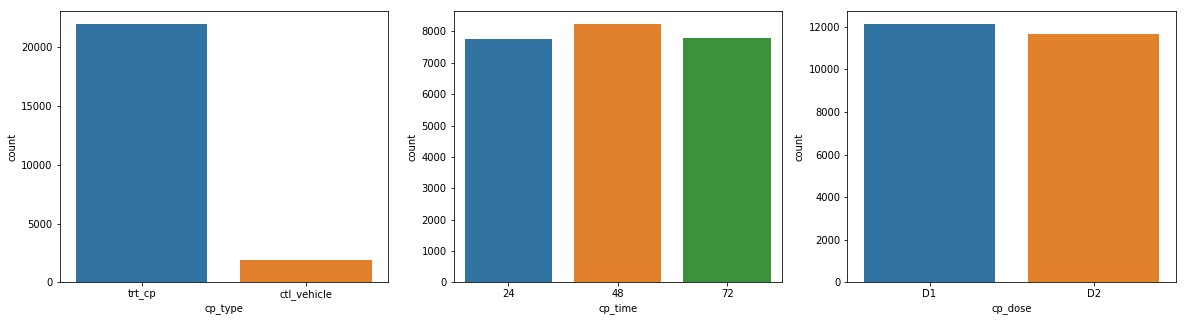

In [16]:
plt.rcParams['figure.figsize']=(20,5)
fig, ax = plt.subplots(1,3)
sns.countplot(df_train["cp_type"], ax = ax[0])
sns.countplot(df_train["cp_time"], ax= ax[1])
sns.countplot(df_train["cp_dose"], ax = ax[2])


- Features g- signify gene expression data.
- Features c- signify cell viability data.
- cp_type indicates samples treated with a compound, trt_cp samples treated with the compounds.
- cp_vehicle or with a control perturbation (ctrl_vehicle); control perturbations have no MoAs.
- cp_time and cp_dose indicate treatment duration (24, 48, 72 hours) and dose (high or low).

A few observations:

1. There are only a few control experiments (denoted by ctl_vehicle), and these have no MoA. 
2. Treatment time is fairly evenly distributed into values 24/48/72 hours. 
3. Treatment dose has 2 values, D1 and D2 which are high and low respectively, which are also fairly evenly distributed.

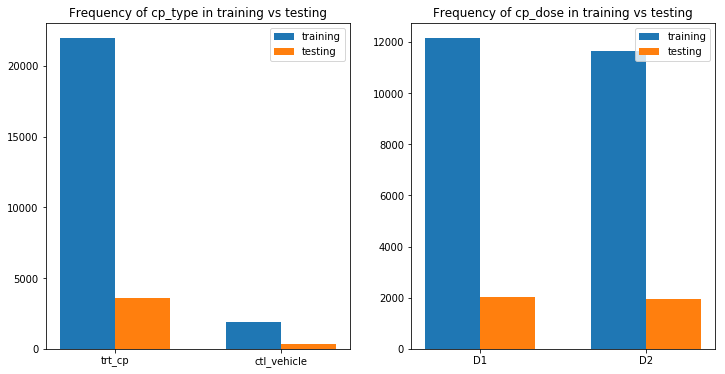

In [55]:
fig, (cp_type_bar, cp_dose_bar) = plt.subplots(nrows=1, ncols=2, figsize=[12, 6])

# plot frequency of cp_type
cp_type_training_count = df_train['cp_type'].value_counts()
cp_type_test_count = df_test['cp_type'].value_counts()
cp_type_label = cp_type_training_count.index
cp_type_width = 1.0
cp_type_bar.bar([0, 3], cp_type_training_count, width=cp_type_width, label = "training")
cp_type_bar.bar([1, 4], cp_type_test_count, width=cp_type_width, label = "testing")
cp_type_bar.set_xticks([0.5, 3.5])
cp_type_bar.set_xticklabels(cp_type_label)
cp_type_bar.set_title('Frequency of cp_type in training vs testing')
cp_type_bar.legend(loc = "upper right")


# plot frequency of cp_dose
cp_dose_training_count = df_train['cp_dose'].value_counts()
cp_dose_test_count = df_test['cp_dose'].value_counts()
cp_dose_label = cp_dose_training_count.index
cp_dose_width = 1.0
cp_dose_bar.bar([0, 3], cp_dose_training_count, width = cp_dose_width, label = "training")
cp_dose_bar.bar([1, 4], cp_dose_test_count, width = cp_dose_width, label = "testing")
cp_dose_bar.set_xticks([0.5, 3.5])
cp_dose_bar.set_xticklabels(cp_dose_label)
cp_dose_bar.set_title('Frequency of cp_dose in training vs testing')
cp_dose_bar.legend(loc = "upper right")

plt.show()

We can see that the amount of cp_type and dose type in training is far greater than in testing. This is as expected since there is more training data than testing data. 

In [18]:
df_train_full = pd.merge(df_train_scored,df_train_unscored,on = "sig_id", how = 'inner')
df_train_full

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# list the columns 
# list(features)
# get all the gene features and cell features
common  = ['sig_id',
 'cp_type',
 'cp_time',
 'cp_dose']


genes = list(filter(lambda x : "g-" in x  , list(df_train)))

cells = list(filter(lambda x : "c-" in x  , list(df_train)))

# **GENE EXPRESSION FEATURES**

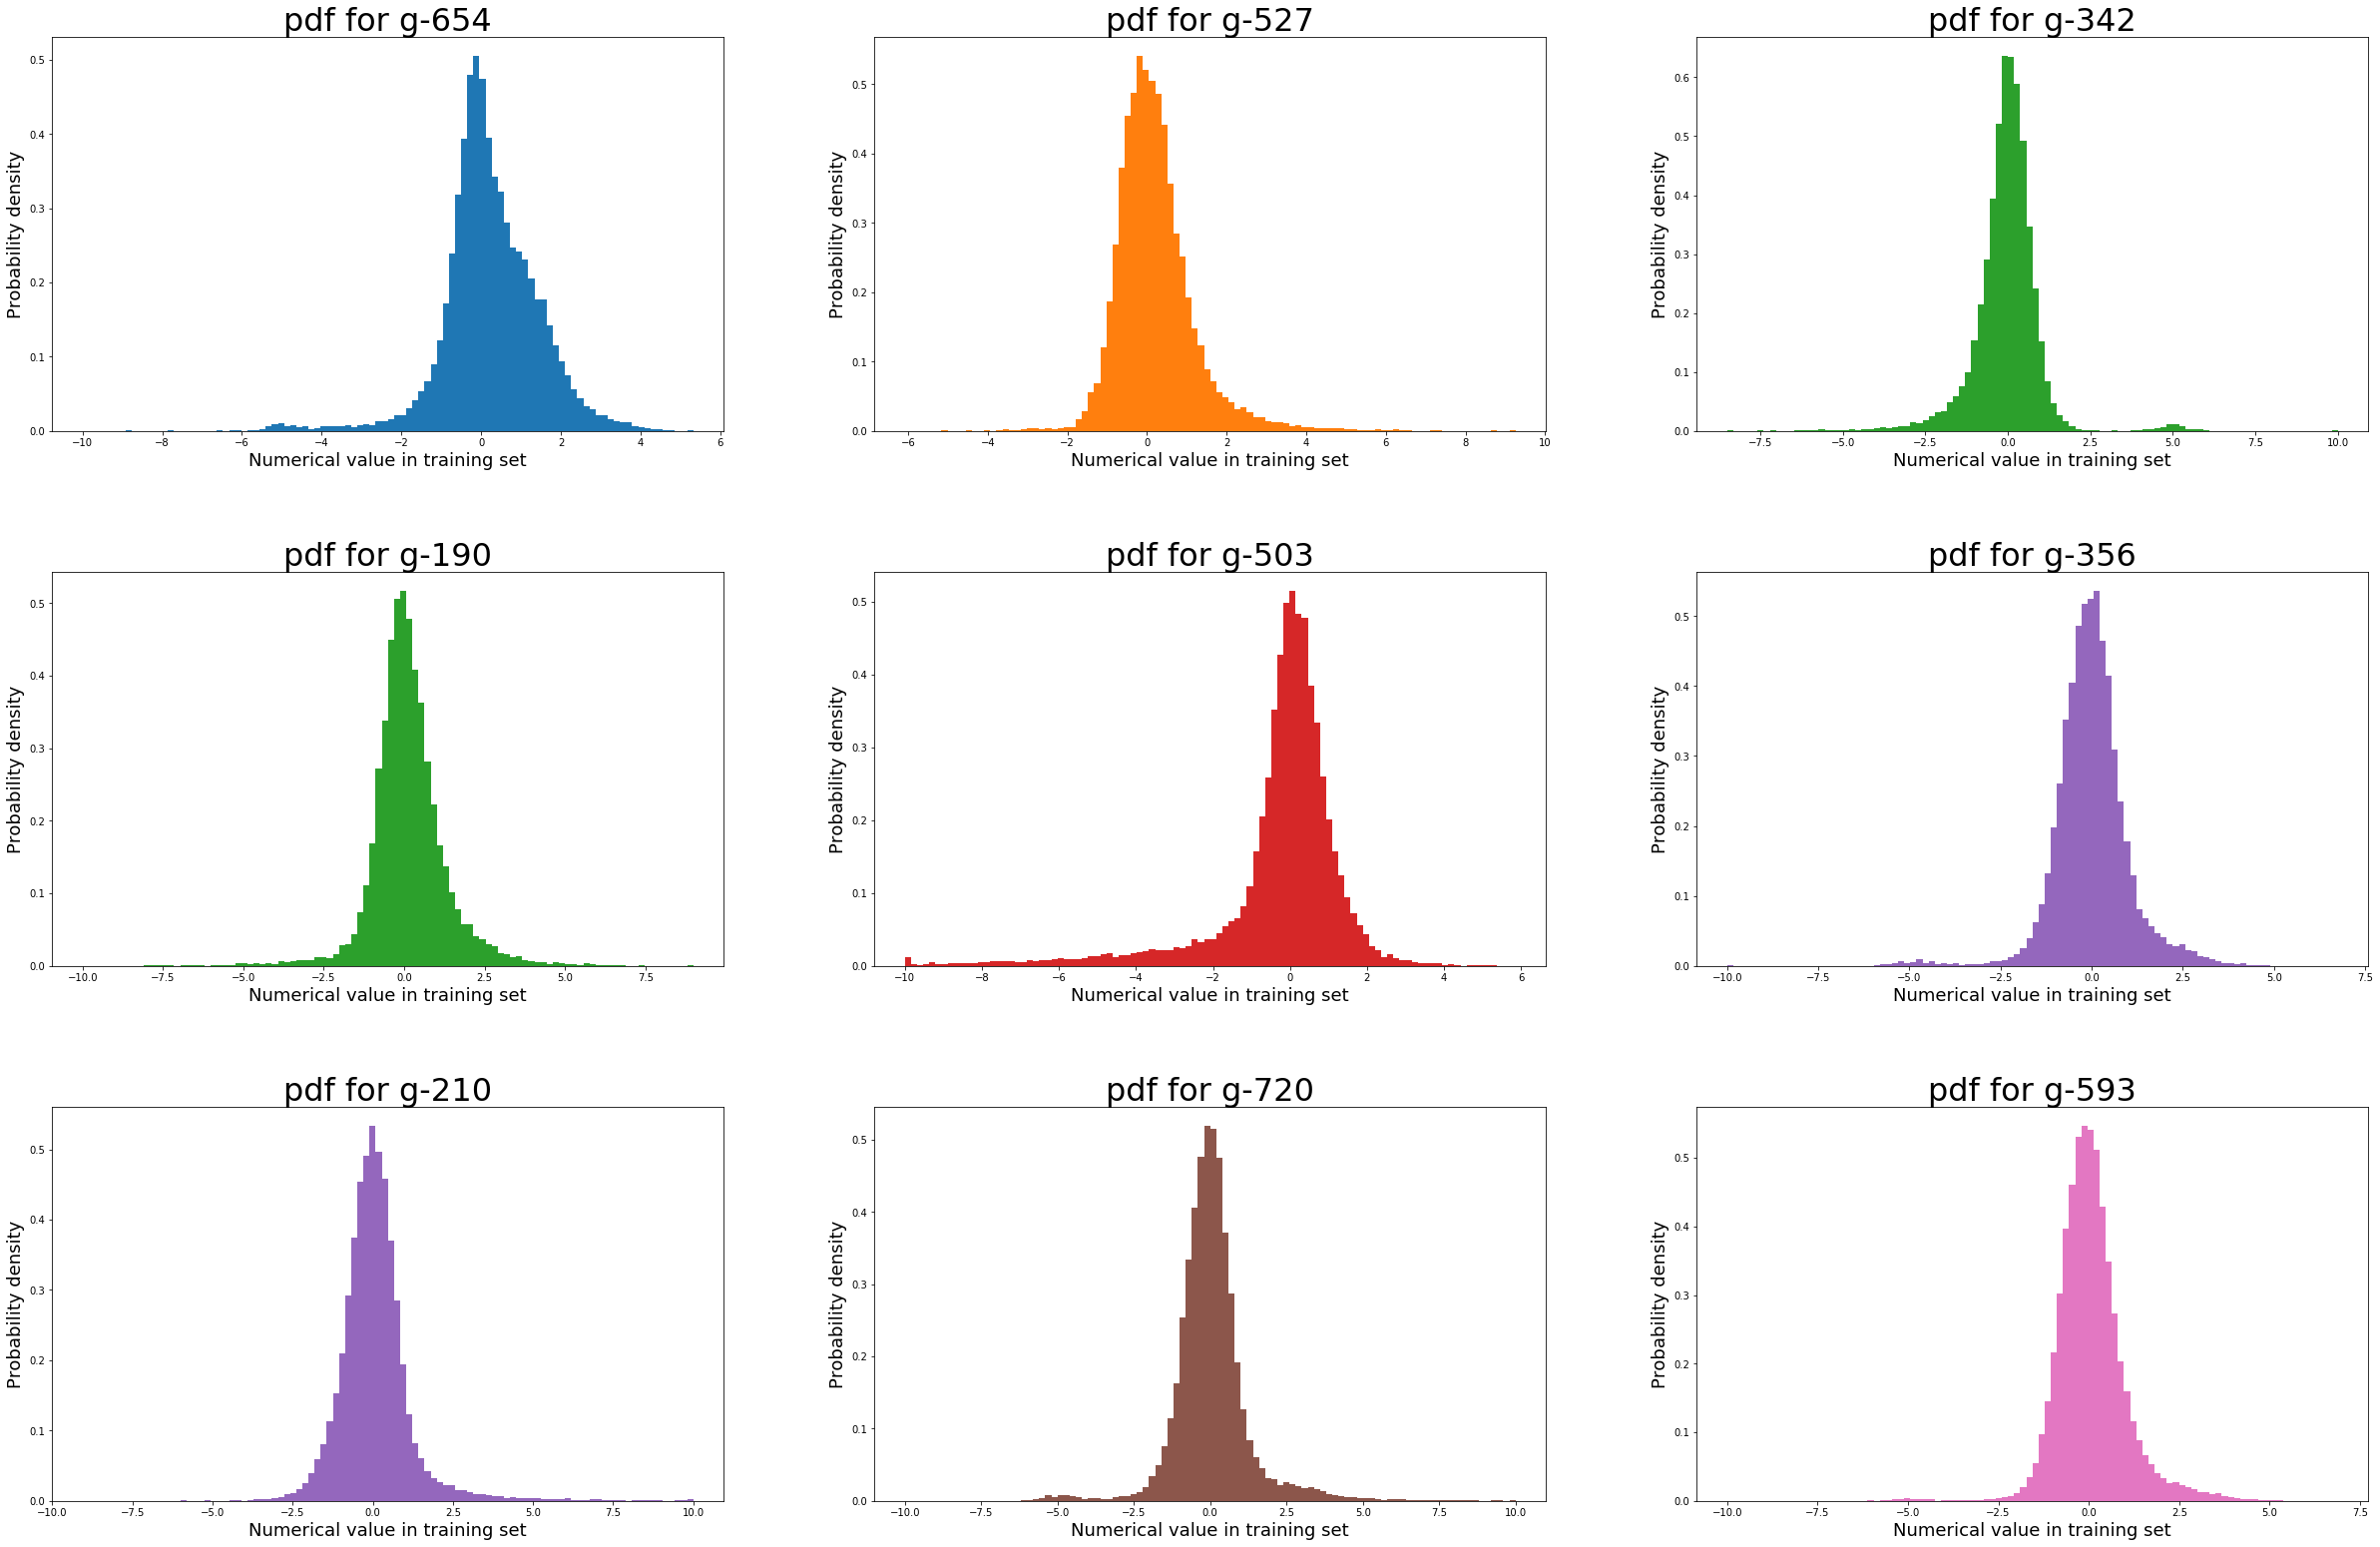

In [20]:
#Let's take a look at the distribution for some genes
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[36,24])
fig.tight_layout(pad=12.0)
cmap = plt.cm.get_cmap("tab10")
colors = cmap.colors
# plot pdf for 9 random g- features
for i in range(nrows):
    for j in range(ncols):
        feature = random.randint(0, 771)
        axis = ax[i][j]
        axis.hist(df_train[f'g-{feature}'], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for g-{feature}', {'fontsize': 32})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})

plt.show()

Distibutions look approximately normal. However, distribution for some genes are skewed, as shown below.

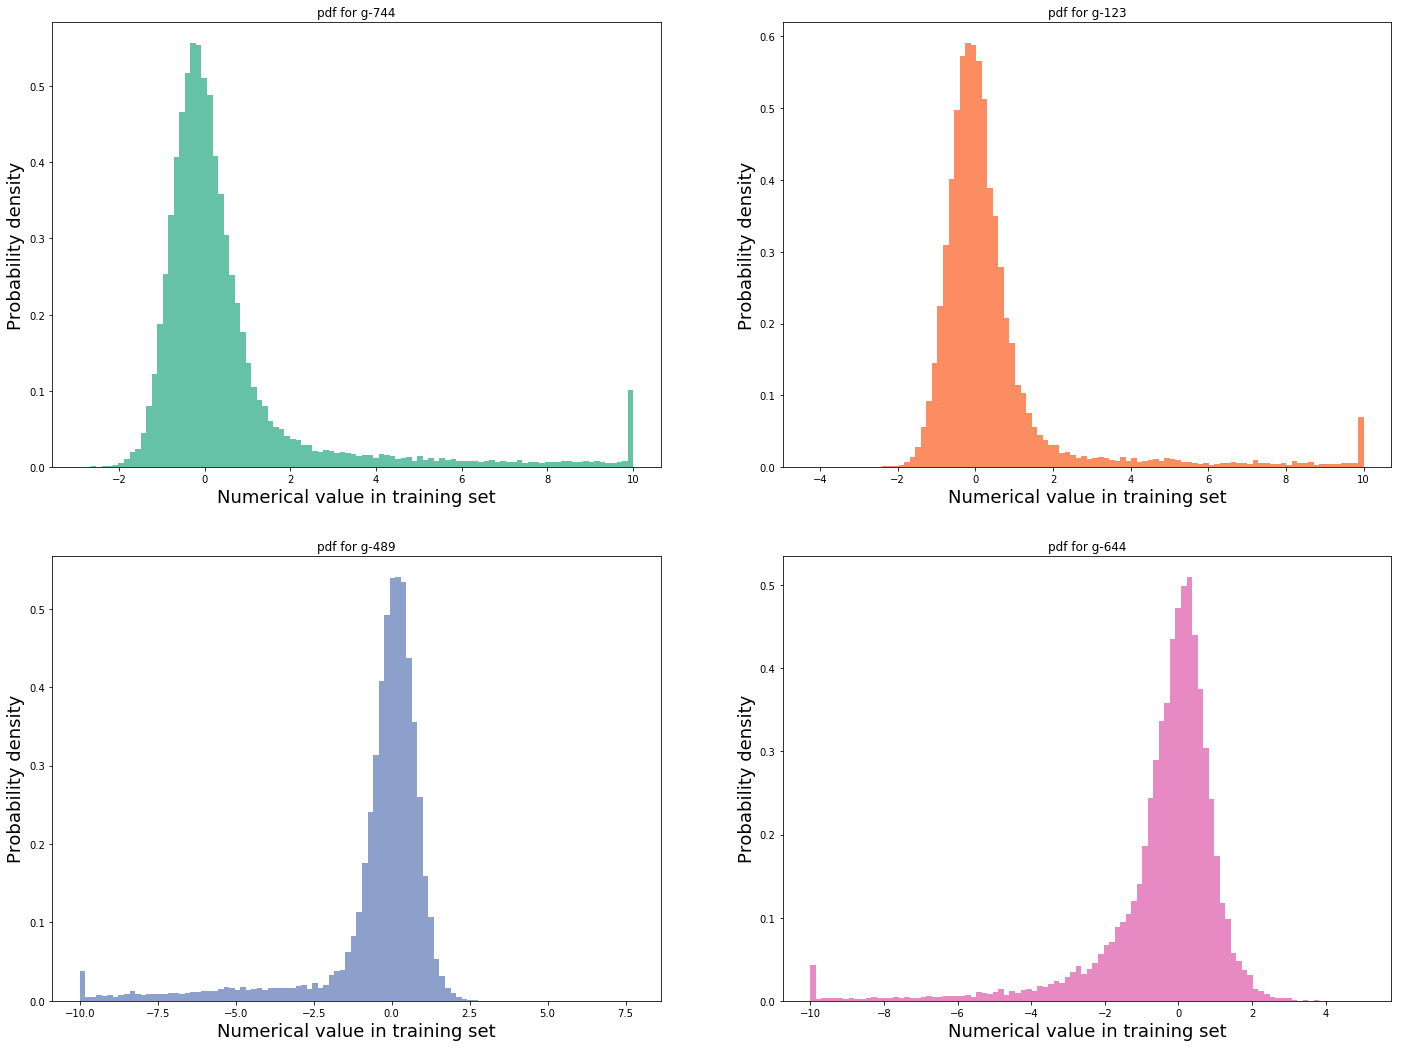

In [21]:
# Some slightly skewed data for features in g
nrows, ncols = 2, 2
fig, ax = plt.subplots(figsize=[24, 18], nrows=nrows, ncols=ncols)
skewed_g = [['g-744', 'g-123'], ['g-489', 'g-644']]
cmap = plt.cm.get_cmap("Set2")
colors = cmap.colors
for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        axis.hist(df_train[skewed_g[i][j]], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for {skewed_g[i][j]}')
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})
plt.show()
#g-744,g-123 g-489, g-644g-23, #g-644, g-413, g-307, g-238

However, we can see some slight skew in the gene data.

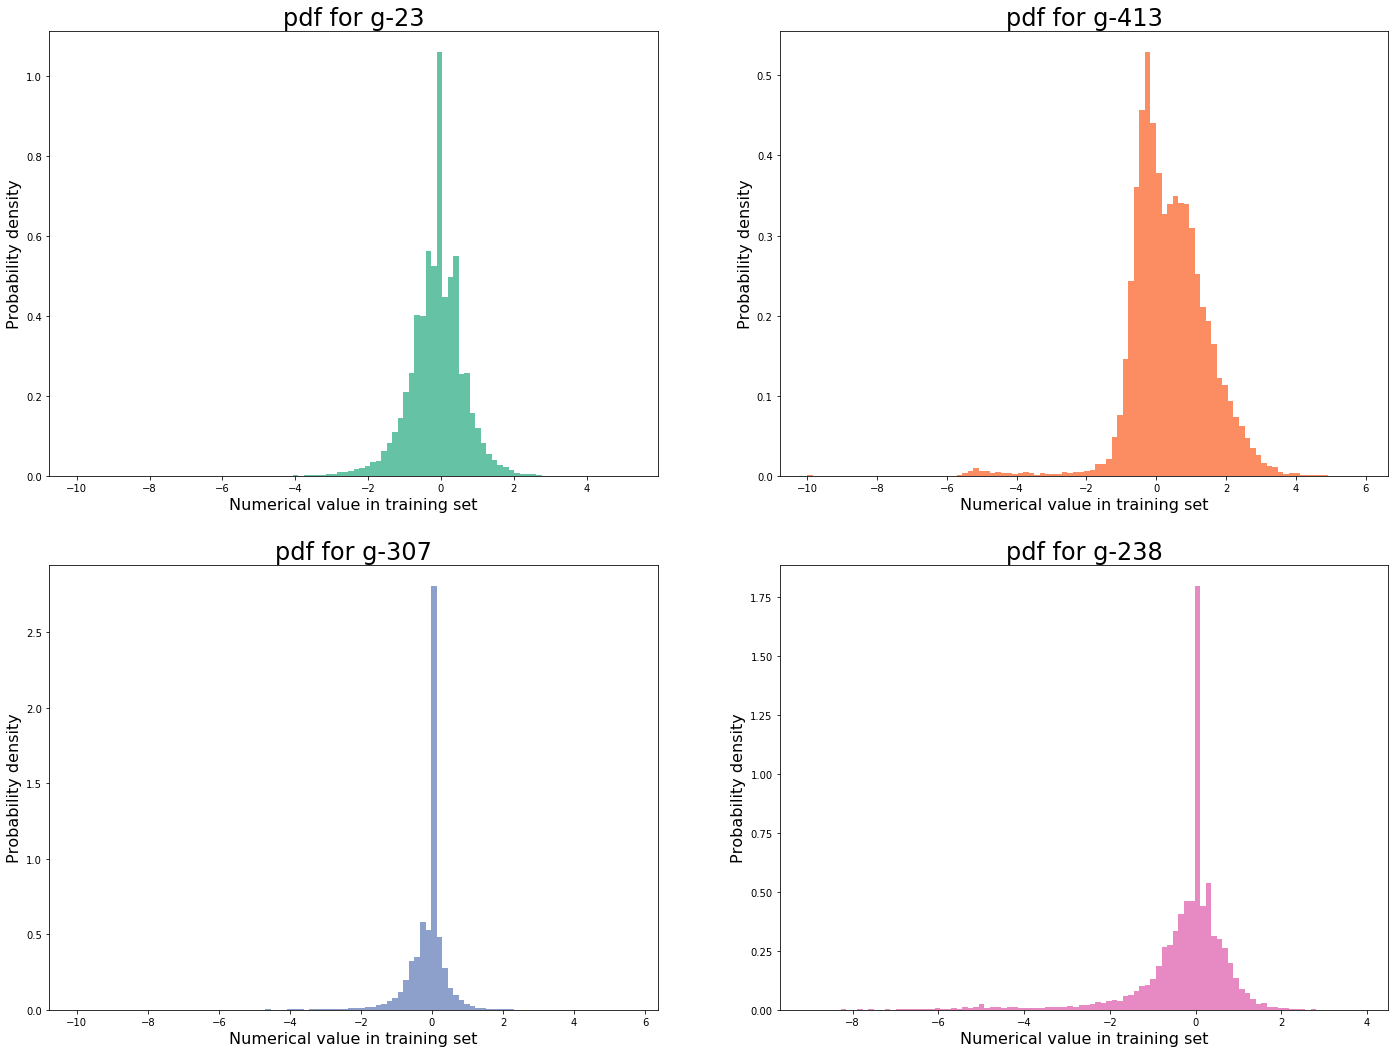

In [22]:
# More slightly skewed data for features in g
nrows, ncols = 2, 2
fig, ax = plt.subplots(figsize=[24, 18], nrows=nrows, ncols=ncols)
skewed_g = [['g-23', 'g-413'], ['g-307', 'g-238']]
cmap = plt.cm.get_cmap("Set2")
colors = cmap.colors
for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        axis.hist(df_train[skewed_g[i][j]], bins=100, density=True, color=colors[2 * i + j])
        axis.set_title(f'pdf for {skewed_g[i][j]}', {'fontsize': 24})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 16})
        axis.set_ylabel("Probability density", {'fontsize': 16})
plt.show()

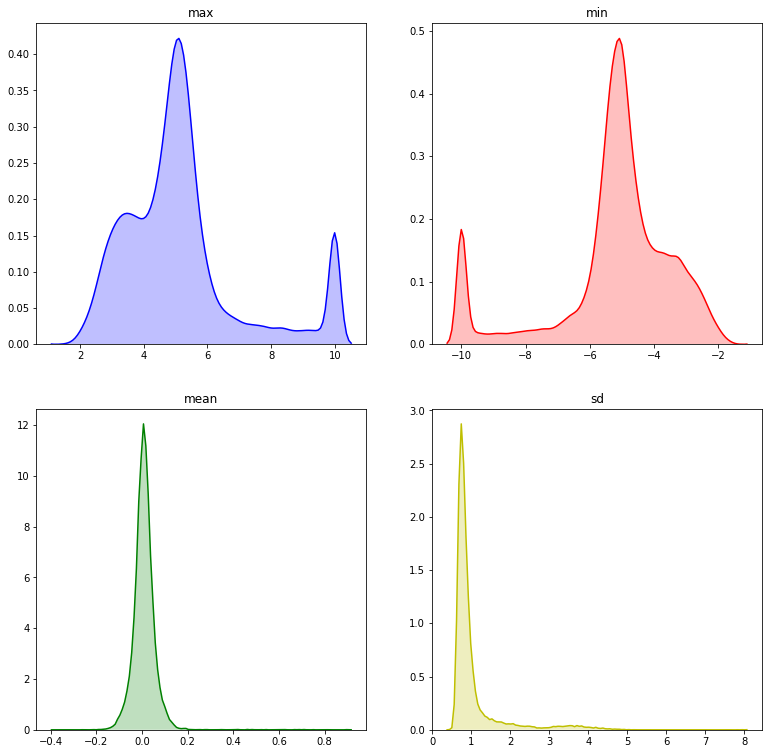

In [23]:
# some stats plot for genes. Find distribution of max/min/mean/std across all gene columns.
fig, axs = plt.subplots(ncols=2 , nrows = 2 , figsize=(13,13))
sns.distplot(df_train[genes].max(axis =1) ,color="b",hist=False, kde_kws={"shade": True}, ax=axs[0][0] ).set(title = 'max')
sns.distplot(df_train[genes].min(axis =1) ,color="r",hist=False, kde_kws={"shade": True}, ax=axs[0][1] ).set(title = 'min')
sns.distplot(df_train[genes].mean(axis =1), color="g",hist=False, kde_kws={"shade": True}, ax=axs[1][0] ).set(title = 'mean')
sns.distplot(df_train[genes].std(axis =1) ,color="y",hist=False, kde_kws={"shade": True}, ax=axs[1][1] ).set(title = 'sd')
plt.show()

1. The means are pretty nicely distributed around zero
2. standard deviations chiefly between 0.5 and 1.5.
3. The min and max are a nice mirror image of each other.
4. There are notable increases around the range of positive/negative 9 - 10(min and max respectively)

BJ's notebook also includes the following analysis for g-307, although i'm not sure what the reason behind examining this particular gene is.

# CELL VIABILITY FEATURES

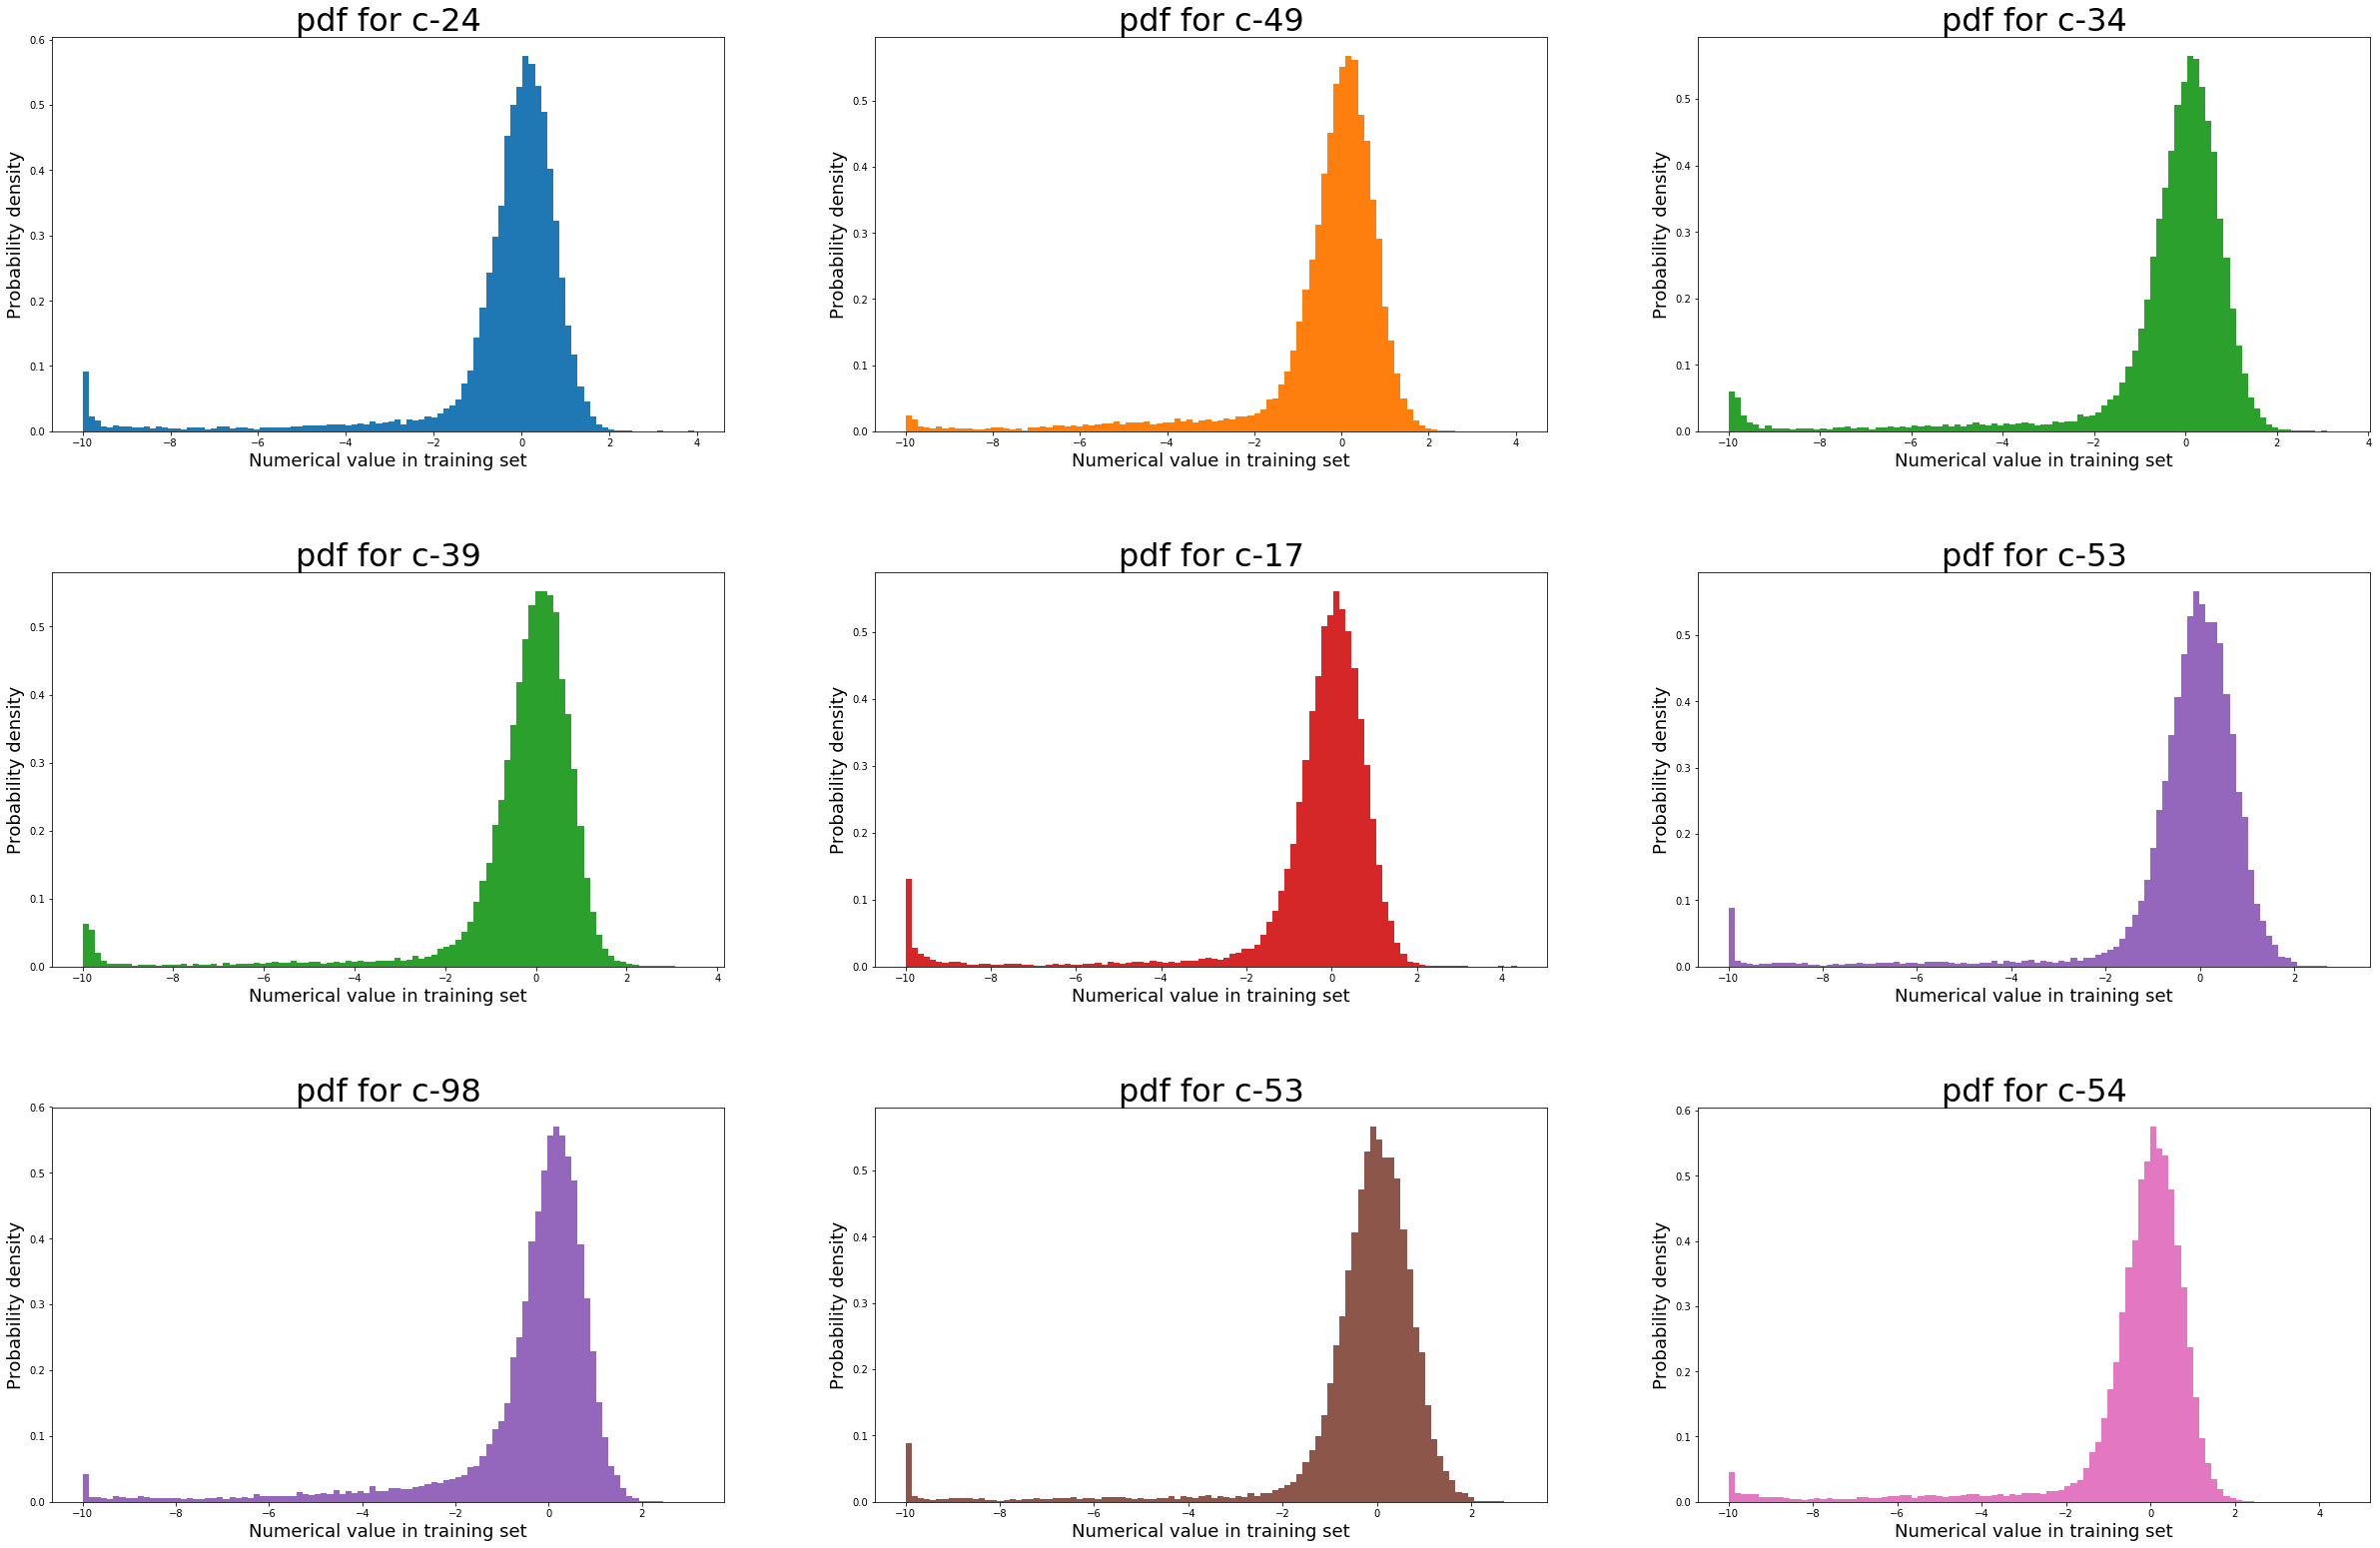

In [24]:
#show histogram plots for randomly chosen cells
nrows, ncols = 3, 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=[36,24])
fig.tight_layout(pad=12.0)
cmap = plt.cm.get_cmap("tab10")
colors=cmap.colors
# plot pdf for 9 random c- features
for i in range(nrows):
    for j in range(ncols):
        feature = random.randint(0, 99)
        axis = ax[i][j]
        axis.hist(df_train[f'c-{feature}'], bins=100, density=True, color=colors[i*2+j])
        axis.set_title(f'pdf for c-{feature}', {'fontsize': 32})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 18})
        axis.set_ylabel("Probability density", {'fontsize': 18})

plt.show()

Convert categorical data in binary values and normalize gene and cell features

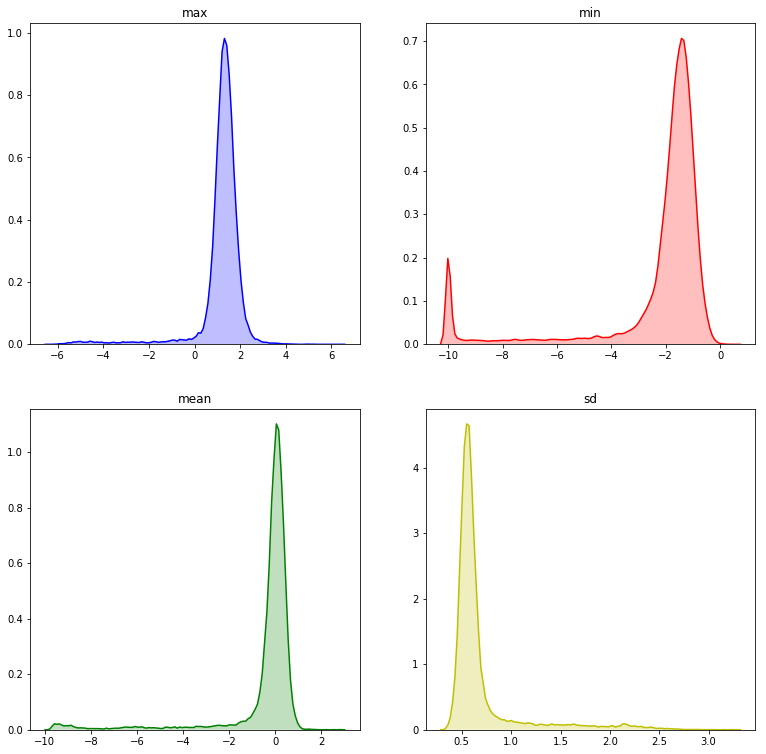

In [25]:
# some stats plot for cell viability. Find distribution of max/min/mean/std across all cell columns. 
fig, axs = plt.subplots(ncols=2 , nrows = 2 , figsize=(13,13))
sns.distplot(df_train[cells].max(axis =1) ,color="b",hist=False, kde_kws={"shade": True}, ax=axs[0][0] ).set(title = 'max')
sns.distplot(df_train[cells].min(axis =1) ,color="r",hist=False, kde_kws={"shade": True}, ax=axs[0][1] ).set(title = 'min')
sns.distplot(df_train[cells].mean(axis =1), color="g",hist=False, kde_kws={"shade": True}, ax=axs[1][0] ).set(title = 'mean')
sns.distplot(df_train[cells].std(axis =1) ,color="y",hist=False, kde_kws={"shade": True}, ax=axs[1][1] ).set(title = 'sd')
plt.show()

Max seems concentrated. On the other hand min is mostly concentrated but jumps at -10.

# ANALYZING TARGET VARIABLE
All the targets are binary columns, indicating whether a certain cell type responds to the drug, or not. Some target classes also measure the type of response; e.g. there is an adrenergic_receptor_agonist class and an adrenergic_receptor_antagonist class. Those should probably not be active for the same sample row.

Our challenge is a multi-label classification problem, and as such the rows (i.e. drug samples) can have multiple MoA’s (i.e. more than one target class can be active). Let’s first look at the distribution of how many target classes can be active at once.

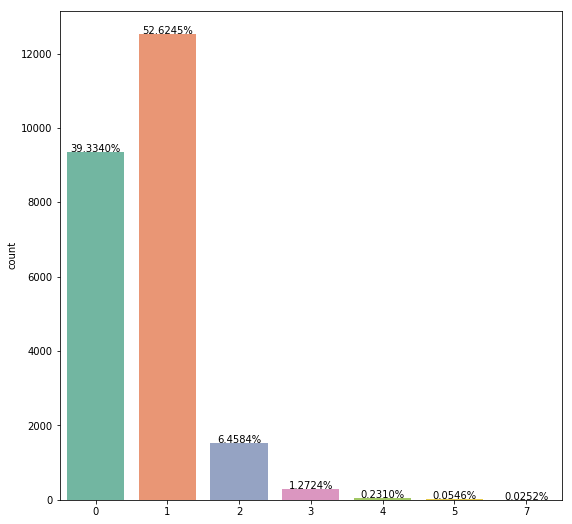

In [26]:
target  = df_train_scored.drop(['sig_id'] , axis =1)

fig, ax = plt.subplots(figsize=(9,9))
ax = sns.countplot(target.sum(axis =1), palette="Set2")
total = float(len(target))

for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.4f}%'.format((height/total)*100),
            ha="center") 

plt.show()

1. About 39% have no Moa annotations. It was expexcted to be a sparse data and since 40% are completly empty this verifies our assumptions.
2. For more than 1 MoA annotation, we see a tail that extends down to 7 simultaneous MoAs (for 0.03% of cases)
3. Majority of the cases have single annotation about 52% cases

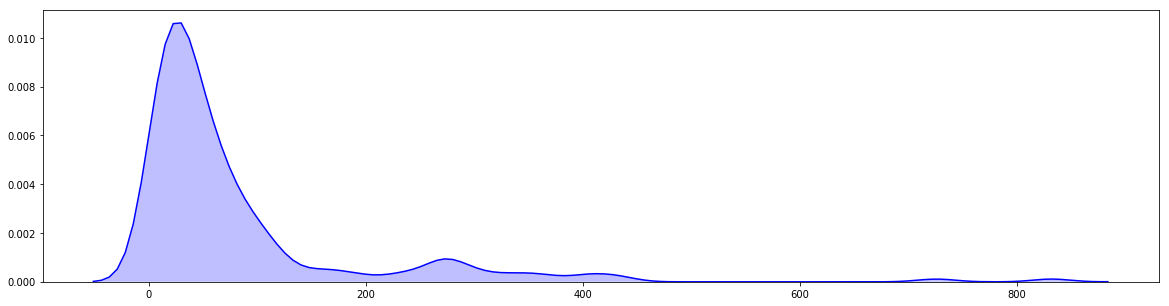

In [27]:
## counts per target class- 
sns.kdeplot(target.sum() , shade = True , color = "b")

Note that most target variables have under 200 occurrences. Recall that we have 206 target variables (206 classes), and 23814 observations.

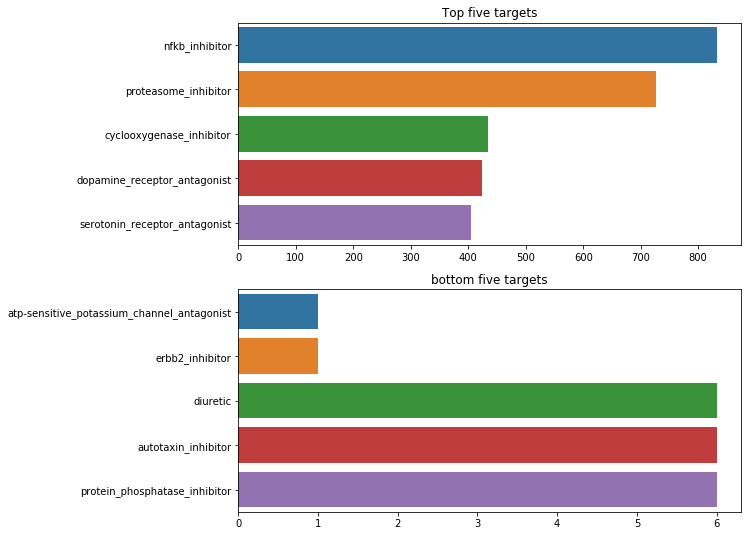

In [28]:
top_targets = pd.Series(target.sum()).sort_values(ascending=False)[:5]
bottom_targets = pd.Series(target.sum()).sort_values()[:5]
fig, axs = plt.subplots(figsize=(9,9) , nrows=2)
sns.barplot(top_targets.values , top_targets.index , ax = axs[0] ).set(title = "Top five targets")
sns.barplot(bottom_targets.values , bottom_targets.index, ax = axs[1] ).set(title = "bottom five targets")
plt.show()

There are two cases with only one anotation
The top target seems to be around 800 (nfkb-inhibitor) also terms like inhibitor antagonist seem to repeat with different suffixes. We can dig into that and try to find patterns between inhibitors etc...

Let's see target distribution based on prefixes separated by '_'

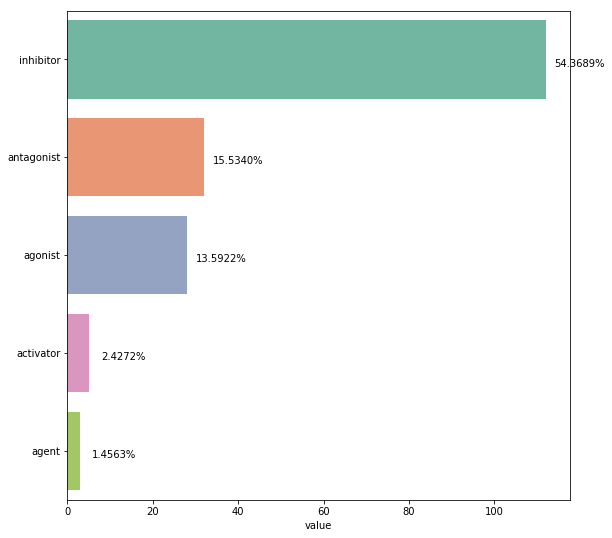

In [29]:
cols = pd.DataFrame({'value': [1 for i in list(target) ]} , index = [i.split('_')[-1] for i in list(target)] )
cols_top_5 = cols.groupby(level=0).sum().sort_values(by = 'value' , ascending = False)[:5]

fig, ax = plt.subplots(figsize=(9,9))

sns.barplot(x = cols_top_5.value , y = cols_top_5.index , palette="Set2" , orient='h')


for p in ax.patches:
    width = p.get_width()
    plt.text(8+p.get_width(), p.get_y()+0.55*p.get_height(),
             '{:1.4f}%'.format((width /206 )*100), # total 206 columns
             ha='center', va='center')

plt.show()

As we can see, most of our targets are inhibitors.

In [30]:
print("Top five suffixes constitue for about ", list(cols_top_5.sum()/cols.sum().values)[0]*100 , "%")

Top five suffixes constitue for about  87.37864077669903 %


In [31]:
# RobustScalar transforms the feature vector by subtracting the median and then dividing by the interquartile range (25% - 75%)
#note: id column is dropped here
df_copy = df_train.copy(deep=True)
df_id = df_train["sig_id"]
df_copy.drop("sig_id", axis = 1, inplace = True)
df_copy['cp_type'] = df_copy['cp_type'].apply(lambda x: 1 if x == "ctl_vehicle" else 0)
df_copy['cp_dose'] = df_copy['cp_dose'].apply(lambda x: 1 if x == "D2" else 0)
scaler = RobustScaler()
X = df_copy.values
X = scaler.fit_transform(X)

df_X = pd.DataFrame(X, columns=df_copy.columns)

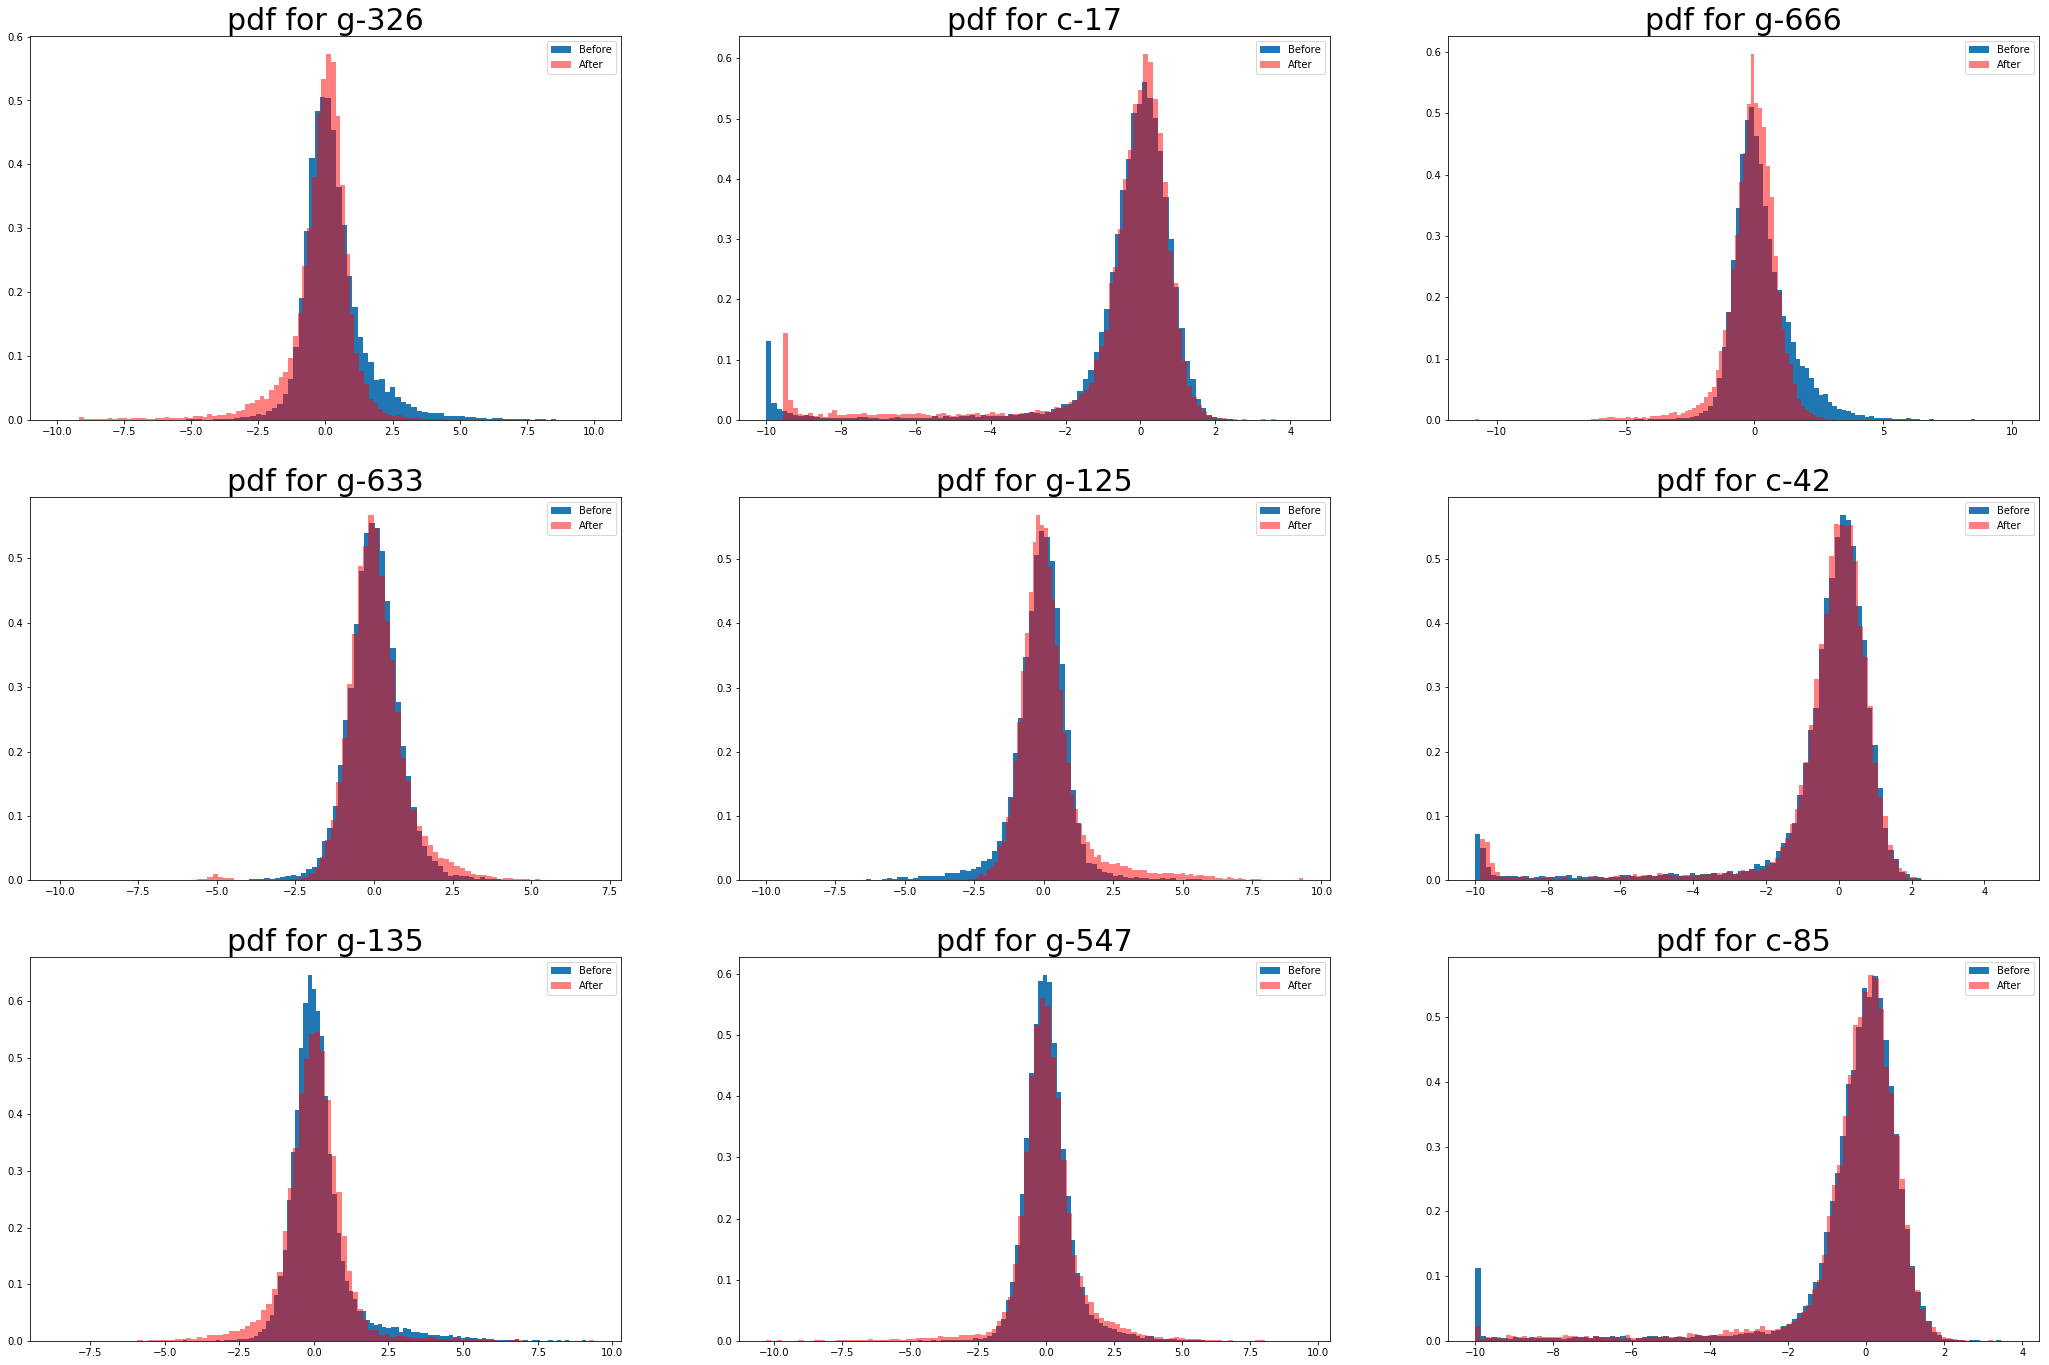

In [32]:
# New pdf for 9 random features
nrows, ncols = 3, 3

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=[36,24])

for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        feature = random.randint(0, 875)
        column_name = df_train.columns[feature]
        axis.hist(df_train.iloc[:, feature], density=True, bins=100)
        axis.hist(df_X.iloc[:, feature],density=True, bins=100, alpha=0.5, color='red')
        axis.set_title(f'pdf for {df_train.columns[feature]}', {'fontsize': 30})
        axis.legend(['Before', 'After'])

plt.show()

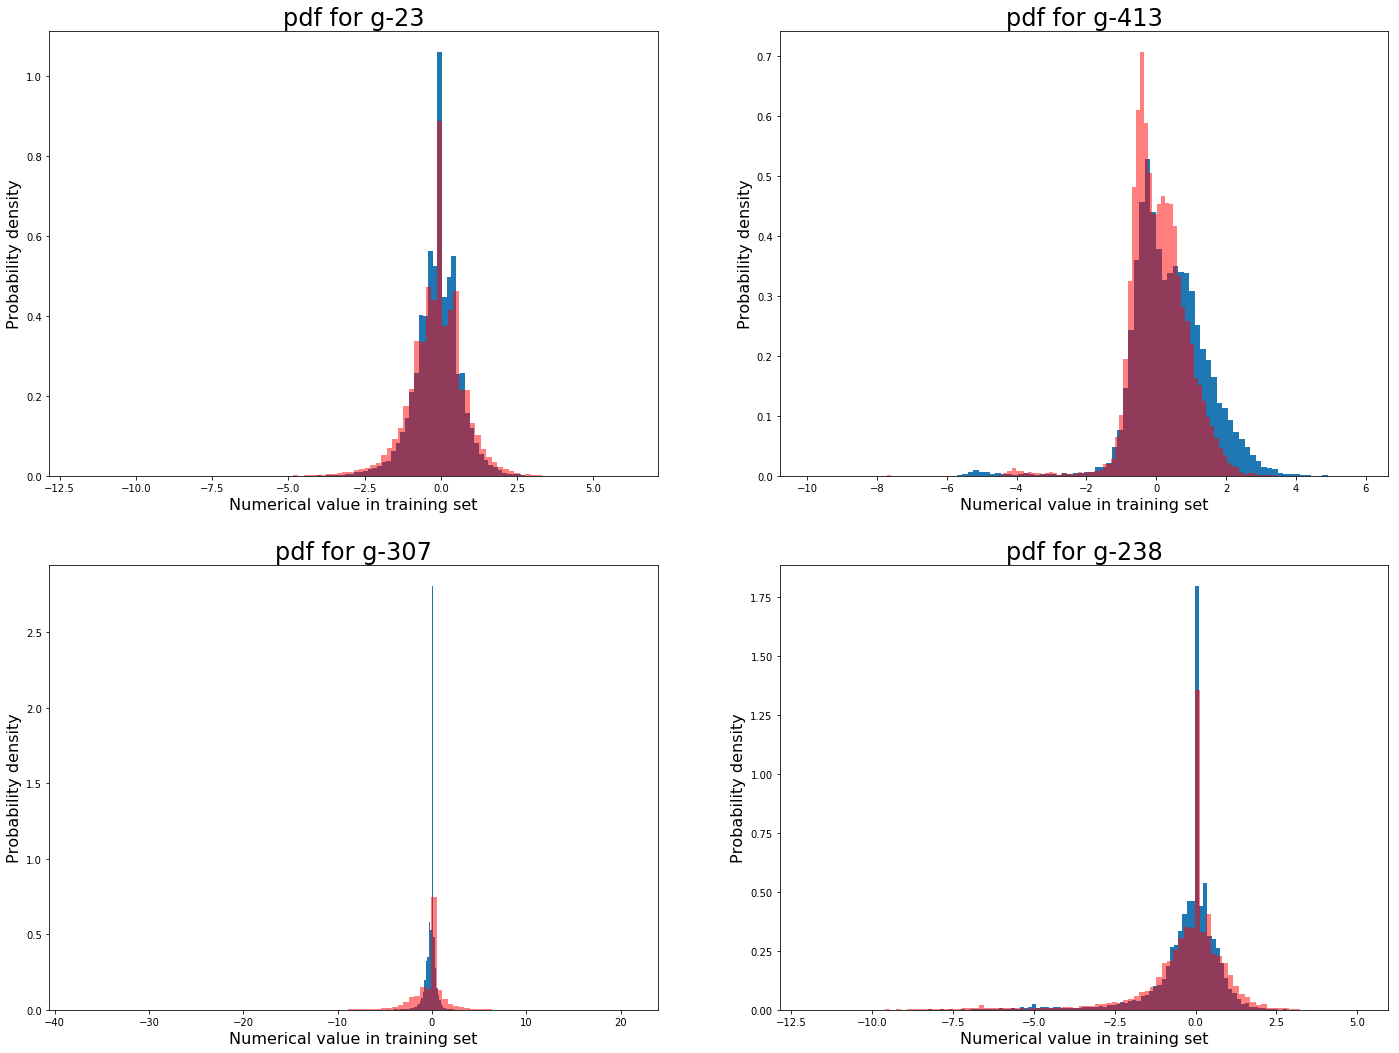

In [33]:
# Robust Scalar on slightly skewed data
nrows, ncols = 2, 2
fig, ax = plt.subplots(figsize=[24, 18], nrows=nrows, ncols=ncols)
skewed_g = [['g-23', 'g-413'], ['g-307', 'g-238']]
cmap = plt.cm.get_cmap("Set2")
colors = cmap.colors
for i in range(nrows):
    for j in range(ncols):
        axis = ax[i][j]
        axis.hist(df_train[skewed_g[i][j]], bins=100, density=True)
        axis.hist(df_X[skewed_g[i][j]], bins=100, density=True, color='red', alpha=0.5)
        axis.set_title(f'pdf for {skewed_g[i][j]}', {'fontsize': 24})
        axis.set_xlabel("Numerical value in training set", {'fontsize': 16})
        axis.set_ylabel("Probability density", {'fontsize': 16})
plt.show()


Correlation Matrix

In [39]:
df_copy.shape == df_train_scored.shape

False

In [34]:
correlation_matrix = np.corrcoef(df_copy, df_train_scored, False)
# remove instances where feature is correlated to feature, and target is correlated to target
correlation_features = correlation_matrix[:875,875:] # shape 875 x 206
df_correlation = pd.DataFrame(correlation_features, index=df_features.columns, columns=df_targets.columns)

TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
# plot correlation matrix for 10 features and 10 targets
feature = random.randint(0, 865)
target = random.randint(0, 196)

correlation_features_submatrix = correlation_features[feature:feature + 10, target: target + 10]
fig, ax = plt.subplots(figsize=[10,10])
ax.imshow(correlation_features_submatrix)

# Loop over data dimensions and create text annotations.
for i in range(10):
    for j in range(10):
        text = ax.text(j, i, round(correlation_features_submatrix[i, j], 4),
                       ha="center", va="center", color="w")

ax.set_yticks(range(10))
ax.set_yticklabels([df_features.columns[f] for f in np.arange(feature, feature +11)])
ax.set_xticks(range(10))
ax.set_xticklabels([df_targets.columns[t] for t in np.arange(target, target + 11)])
plt.xticks(rotation=45, ha='right')
plt.show()

# Let's perform some bivariate analysis here

C:\Users\Sanraj\anaconda3\envs\fastai\lib\site-packages\seaborn\axisgrid.py:723: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


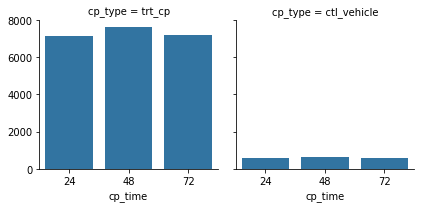

In [40]:
features = df_train
g = sns.FacetGrid(features, col='cp_type')
g.map(sns.countplot, 'cp_time')

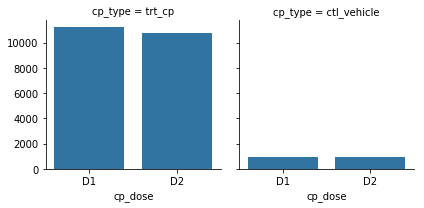

In [41]:
g  = sns.FacetGrid(features, col="cp_type" )
g.map(sns.countplot , 'cp_dose'  )
plt.show()

In the above two cells, we note that cp_type=ctrl_vehicle is far less than cp_type=trt_cp, as expected.

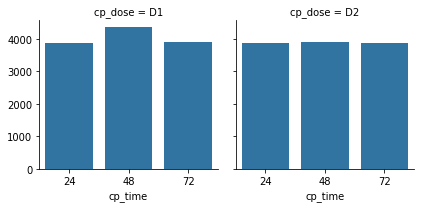

In [42]:
g  = sns.FacetGrid(features, col="cp_dose" )
g.map(sns.countplot , 'cp_time'  )
plt.show()

Also, we see that D1 (=low dose) is administered more for the 48h group compared to the other 2 groups. The rest of the cp_time buckets get relatively similar administered doses.

In [43]:
# compute the means of cells and genes for further analysis

features['c_mean'] = features[cells].mean(axis=1)
features['g_mean'] = features[genes].mean(axis=1)

In [44]:
# helper functions

def plt_dist(feature, mean_type, plt_num):
    plt.subplot(plt_num)
    for i in features[feature].unique():
        sns.distplot(features[features[feature]==i][mean_type], label=i, hist=False, kde_kws={"shade": True})
    plt.title(f"{mean_type} based on {feature}")
    plt.legend()

def plt_box(feature, mean_type, plt_num):
    plt.subplot(plt_num)
    sns.boxplot(x=features[feature], y=features[mean_type])
    plt.title(f"{mean_type} based on {feature}")
    plt.legend()
    

## Analysis of gene expression vs common variables

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


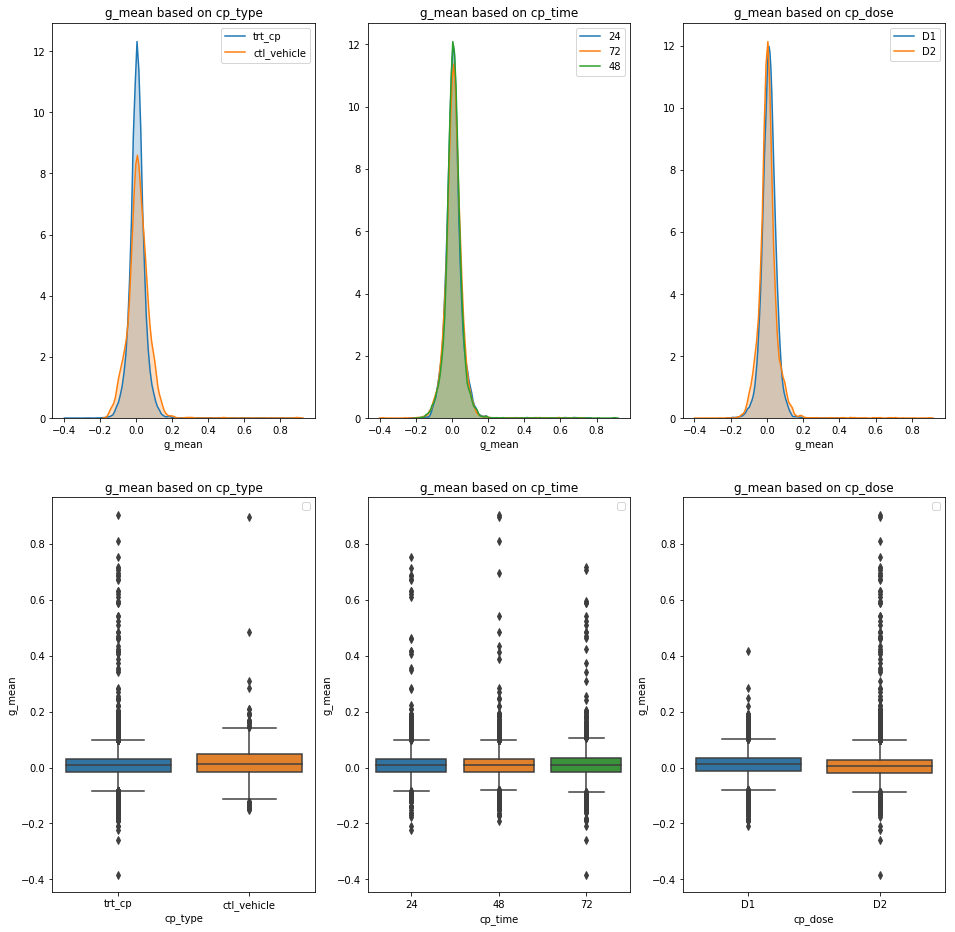

In [45]:
fig, axs = plt.subplots(figsize=(16,16), nrows=2, ncols=3)


plt_details = [
        (231, "g_mean", "cp_type"),
        (232, "g_mean", "cp_time"),
        (233, "g_mean", "cp_dose"),    
        (234, "g_mean", "cp_type"),
        (235, "g_mean", "cp_time"),
        (236, "g_mean", "cp_dose"),
        ]


for (plt_num, mean_type, feature) in plt_details[:3]:
    plt_dist(feature, mean_type, plt_num)
    
for (plt_num, mean_type, feature) in plt_details[3:6]:
    plt_box(feature, mean_type, plt_num)
    

plt.show()

## Analysis of cell viability vs common variables

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


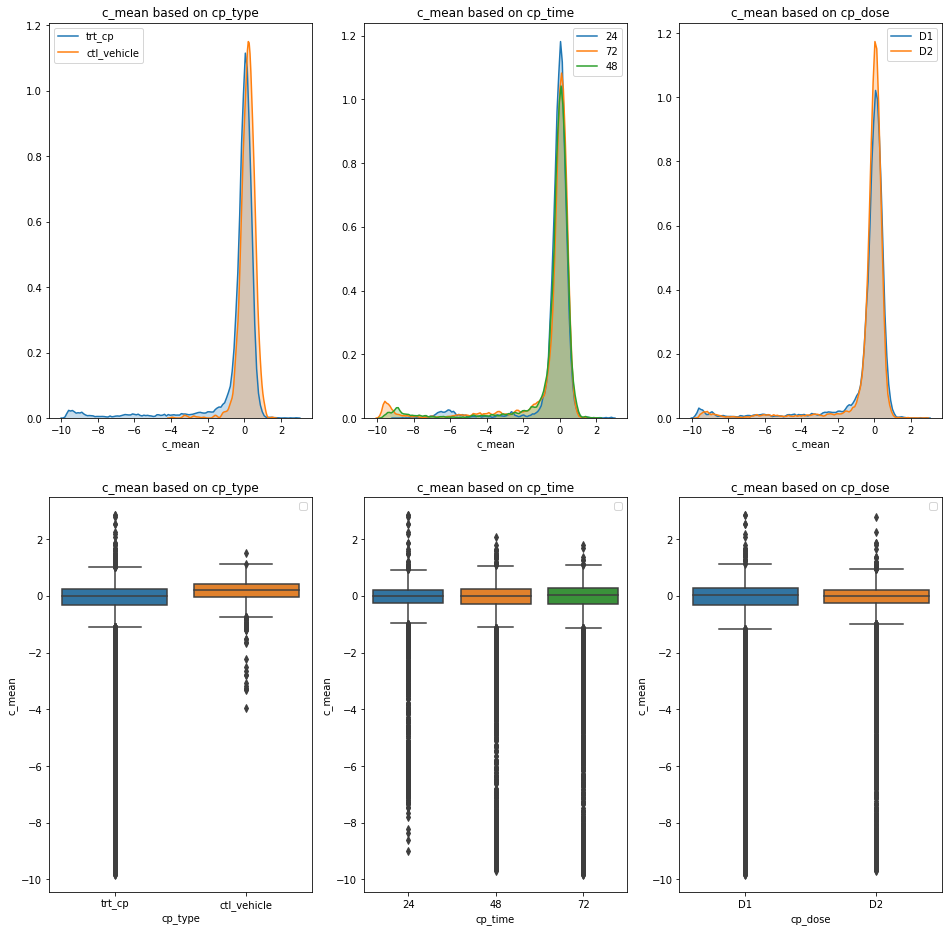

In [46]:
fig, axs = plt.subplots(figsize=(16,16), nrows=2, ncols=3)


plt_details = [
        (231, "c_mean", "cp_type"),
        (232, "c_mean", "cp_time"),
        (233, "c_mean", "cp_dose"),    
        (234, "c_mean", "cp_type"),
        (235, "c_mean", "cp_time"),
        (236, "c_mean", "cp_dose"),
        ]


for (plt_num, mean_type, feature) in plt_details[:3]:
    plt_dist(feature, mean_type, plt_num)
    
for (plt_num, mean_type, feature) in plt_details[3:6]:
    plt_box(feature, mean_type, plt_num)
    

plt.show()

As seen in the univariate analysis for cells and genes, cells have a negative tail and genes have a positive tail.

The distribution on the basis of the common variables (cp_time, cp_dose, cp_type) are similar with a slight difference in the negative (extreme) values for cells and positive (extreme) values for genes.

## Target vs common variables

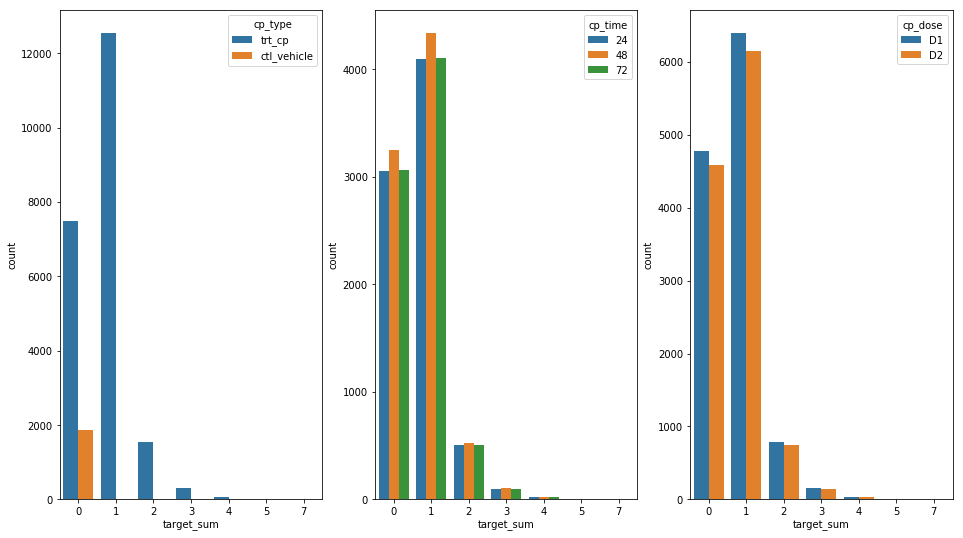

In [47]:
target = df_train_scored.drop(['sig_id'] , axis =1)


feat_target  = pd.merge(features , df_train_scored , how = "inner" , on = ['sig_id','sig_id'])
target_cols = list(target)
feat_target["target_sum"] = feat_target[target_cols].sum(axis =1)
feat_target.drop("sig_id" , axis = 1, inplace = True)

fig,ax = plt.subplots(figsize=(16,9))
plt.subplot(131)
sns.countplot(x = 'target_sum' , hue= 'cp_type', data = feat_target)
plt.subplot(132)
sns.countplot(x = 'target_sum' , hue= 'cp_time', data = feat_target)
plt.subplot(133)
sns.countplot(x = 'target_sum' , hue= 'cp_dose', data = feat_target)

plt.show()

Two observations here:
1. ctrl_vehicle has no target annotations (expected)
2. most of the obs have one target annotation

## Target vs g_mean and c_mean

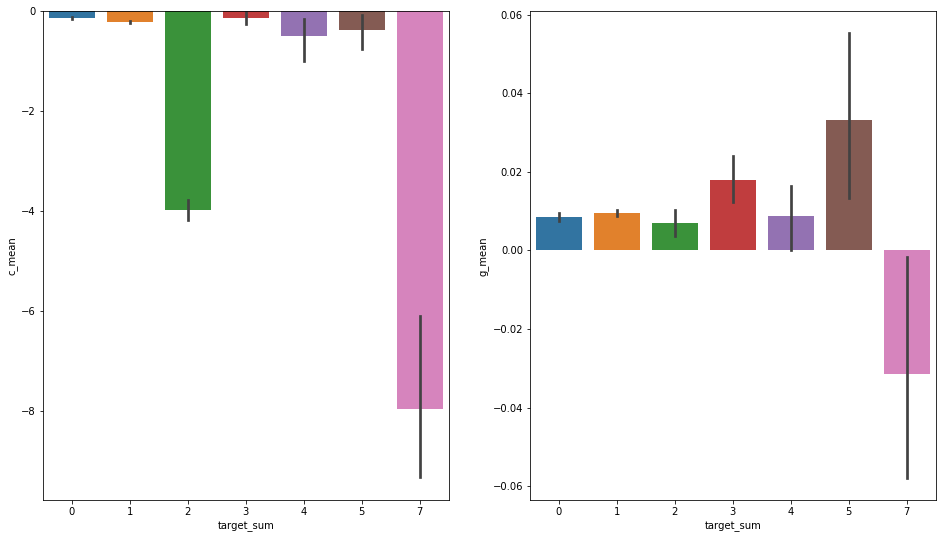

In [48]:
fig,ax = plt.subplots(figsize=(16,9))
plt.subplot(121)
sns.barplot(x = 'target_sum' , y= 'c_mean', data = feat_target)
plt.subplot(122)
sns.barplot(x = 'target_sum' , y= 'g_mean', data = feat_target)

plt.show()

This is quite interesting. Here, we note that the negative tails are in effect for c_mean. But for genes only, g_mean is negative for only 7 target_sum, warranting further investigation.

# Multivariate analysis and heatmaps

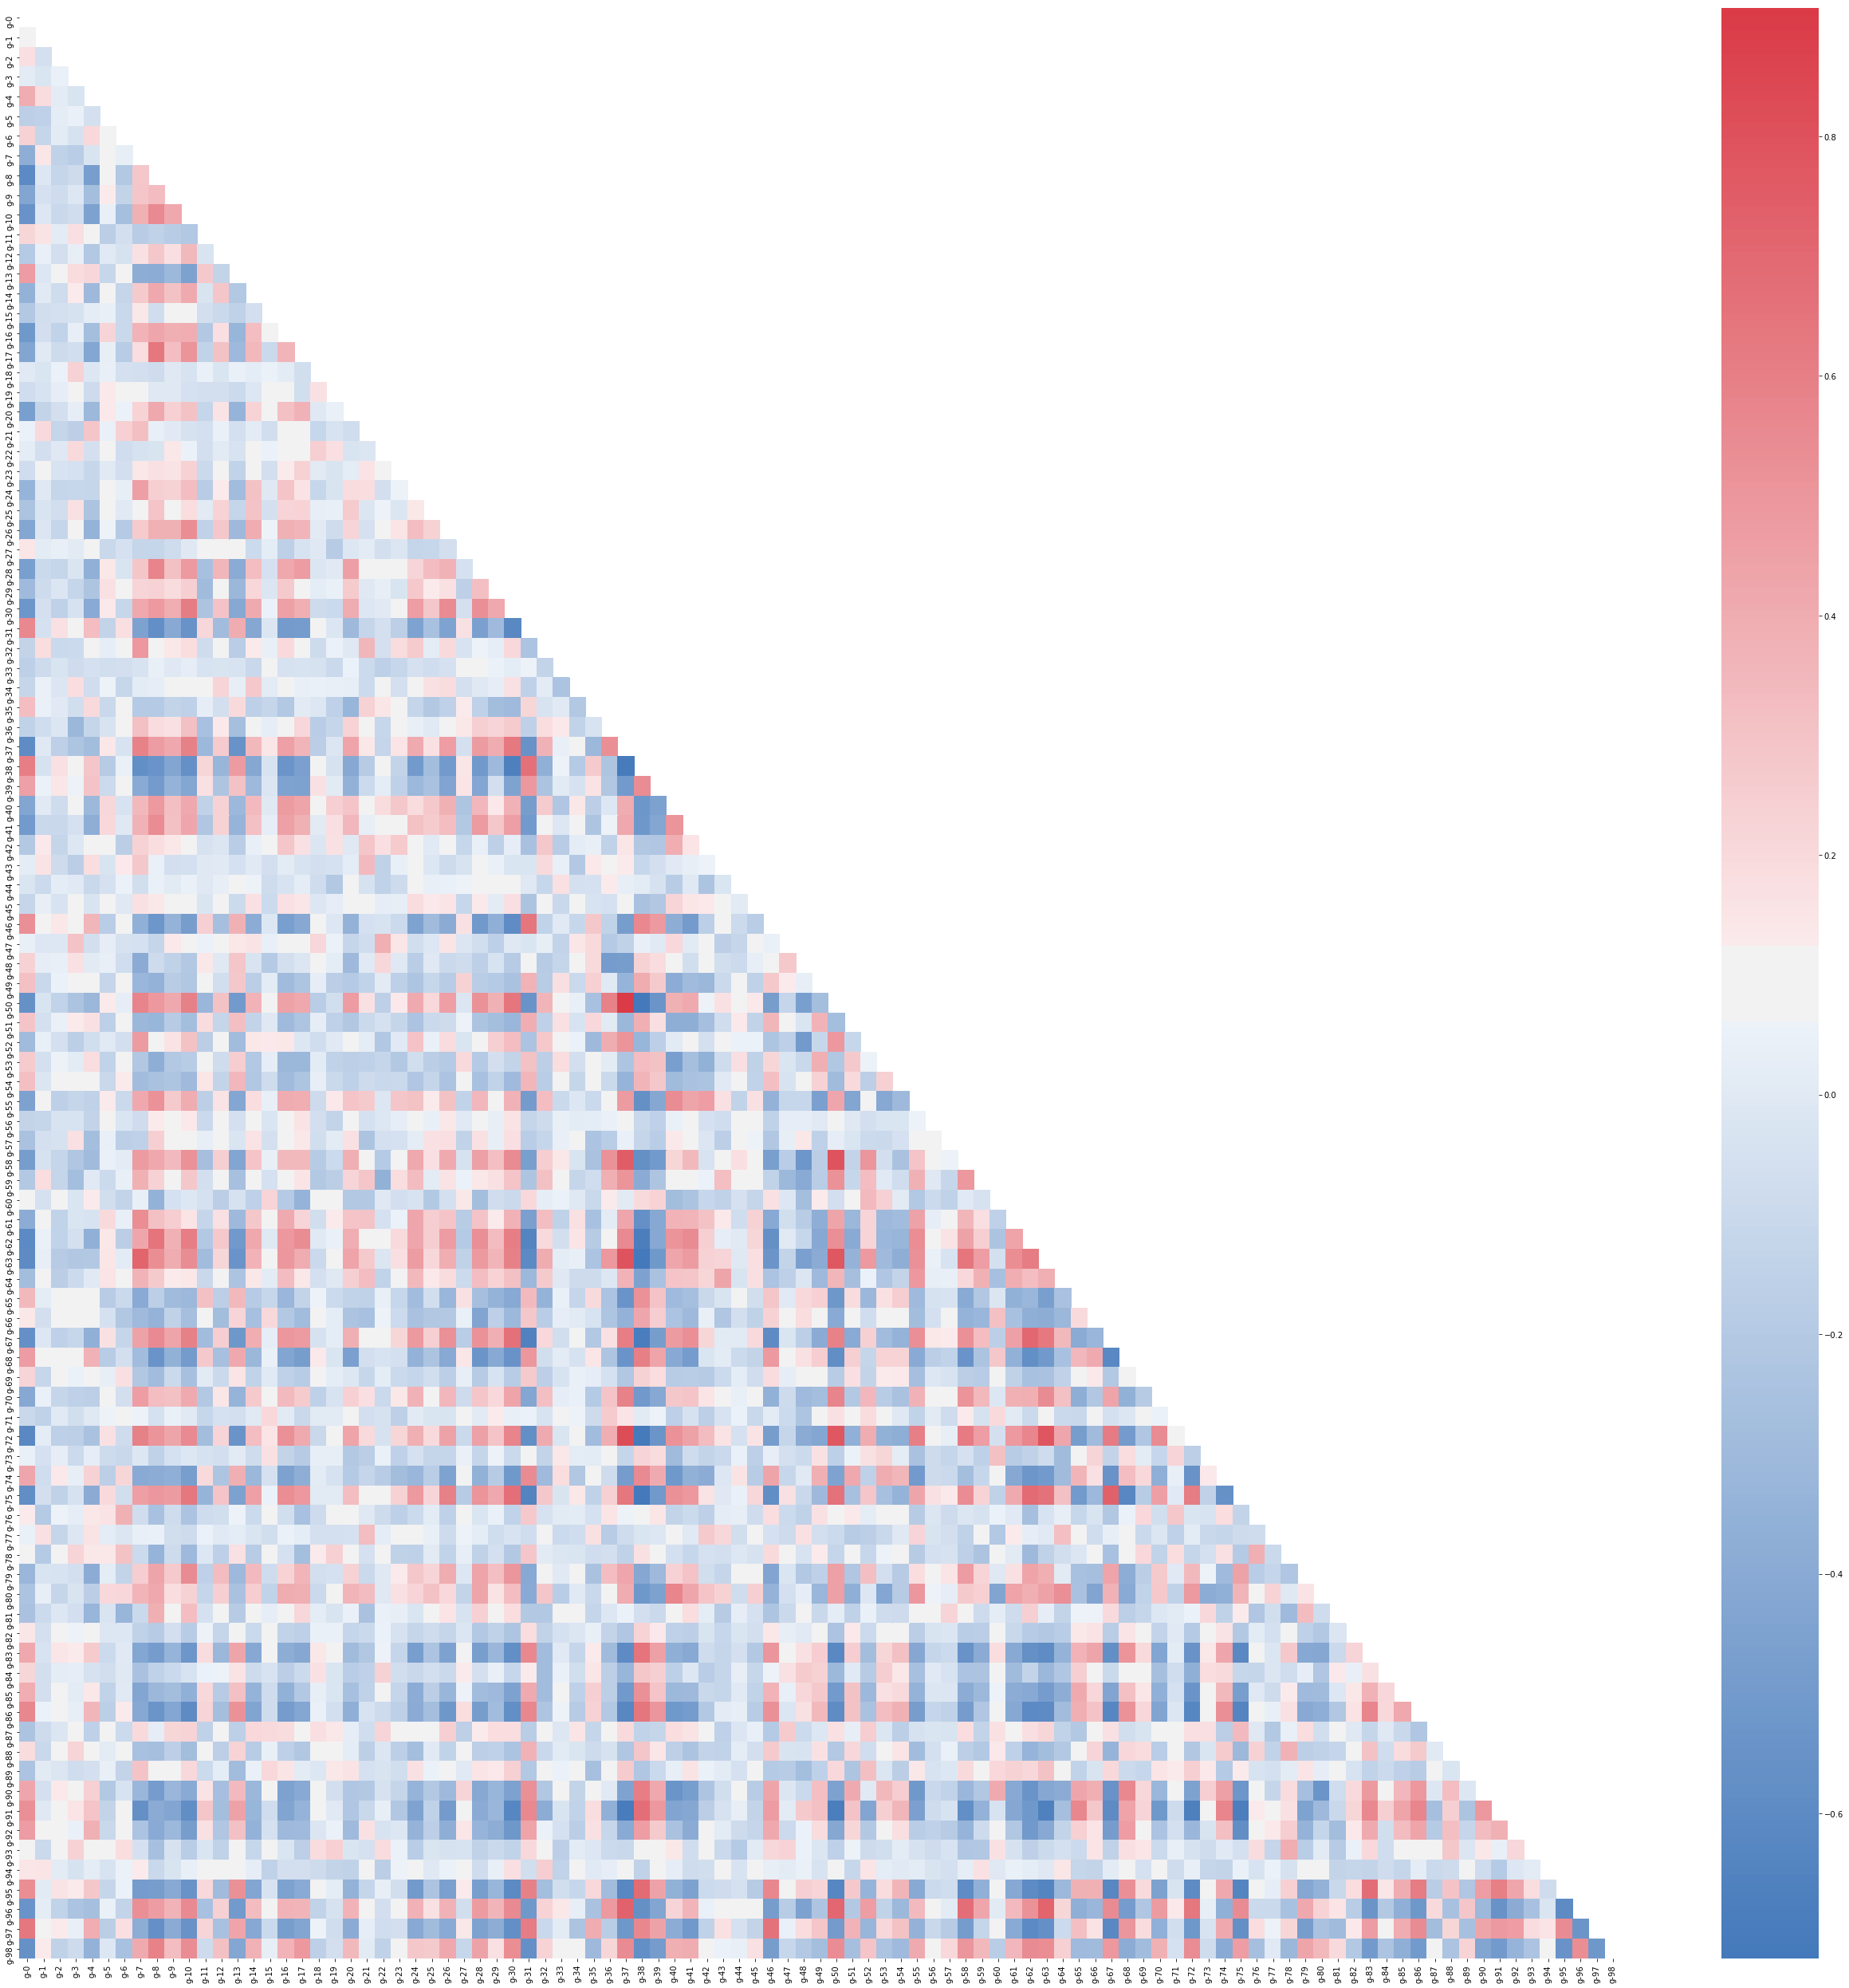

In [49]:
corr = features[genes[:99]].corr() # taking only first 99 genes other wise its a mess
f, ax = plt.subplots(figsize=(45, 45))
# Add diverging colormap from red to blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap
sns.heatmap(corr,  mask = mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns , cmap=cmap)
plt.show()

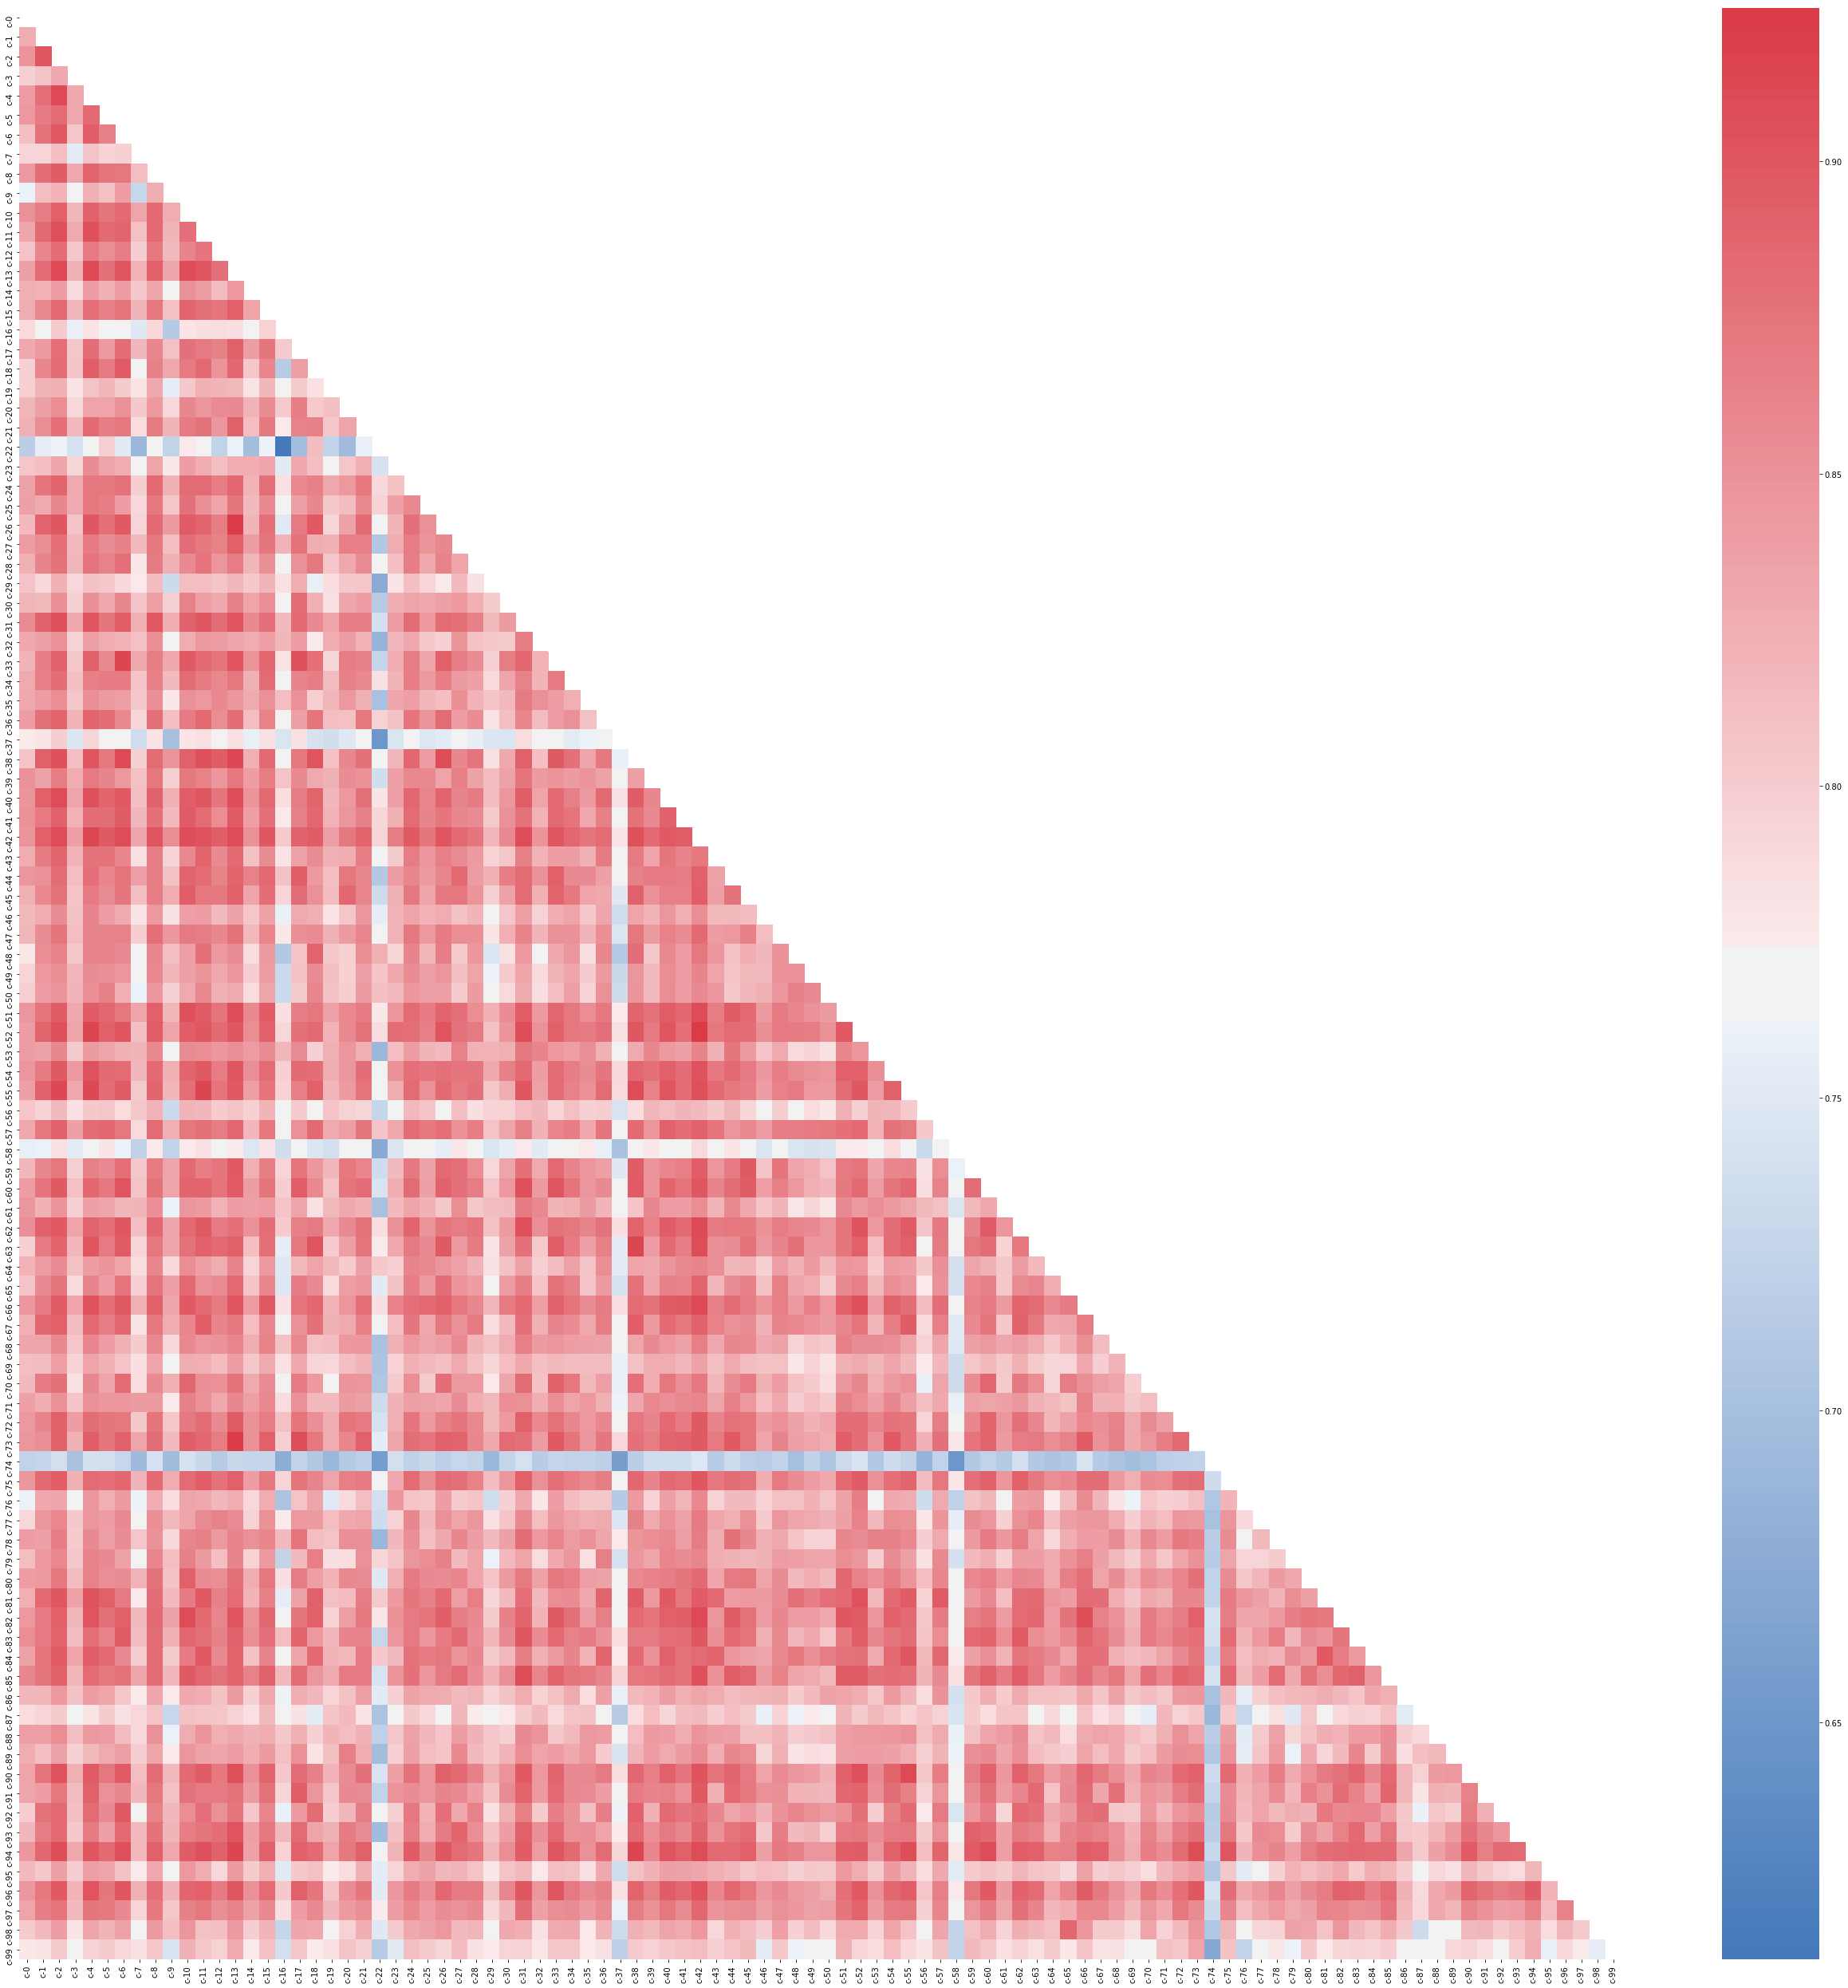

In [50]:
corr = features[cells].corr()
f, ax = plt.subplots(figsize=(45, 45))
# Add diverging colormap from red to blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap
sns.heatmap(corr,  mask = mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns , cmap=cmap)
plt.show()

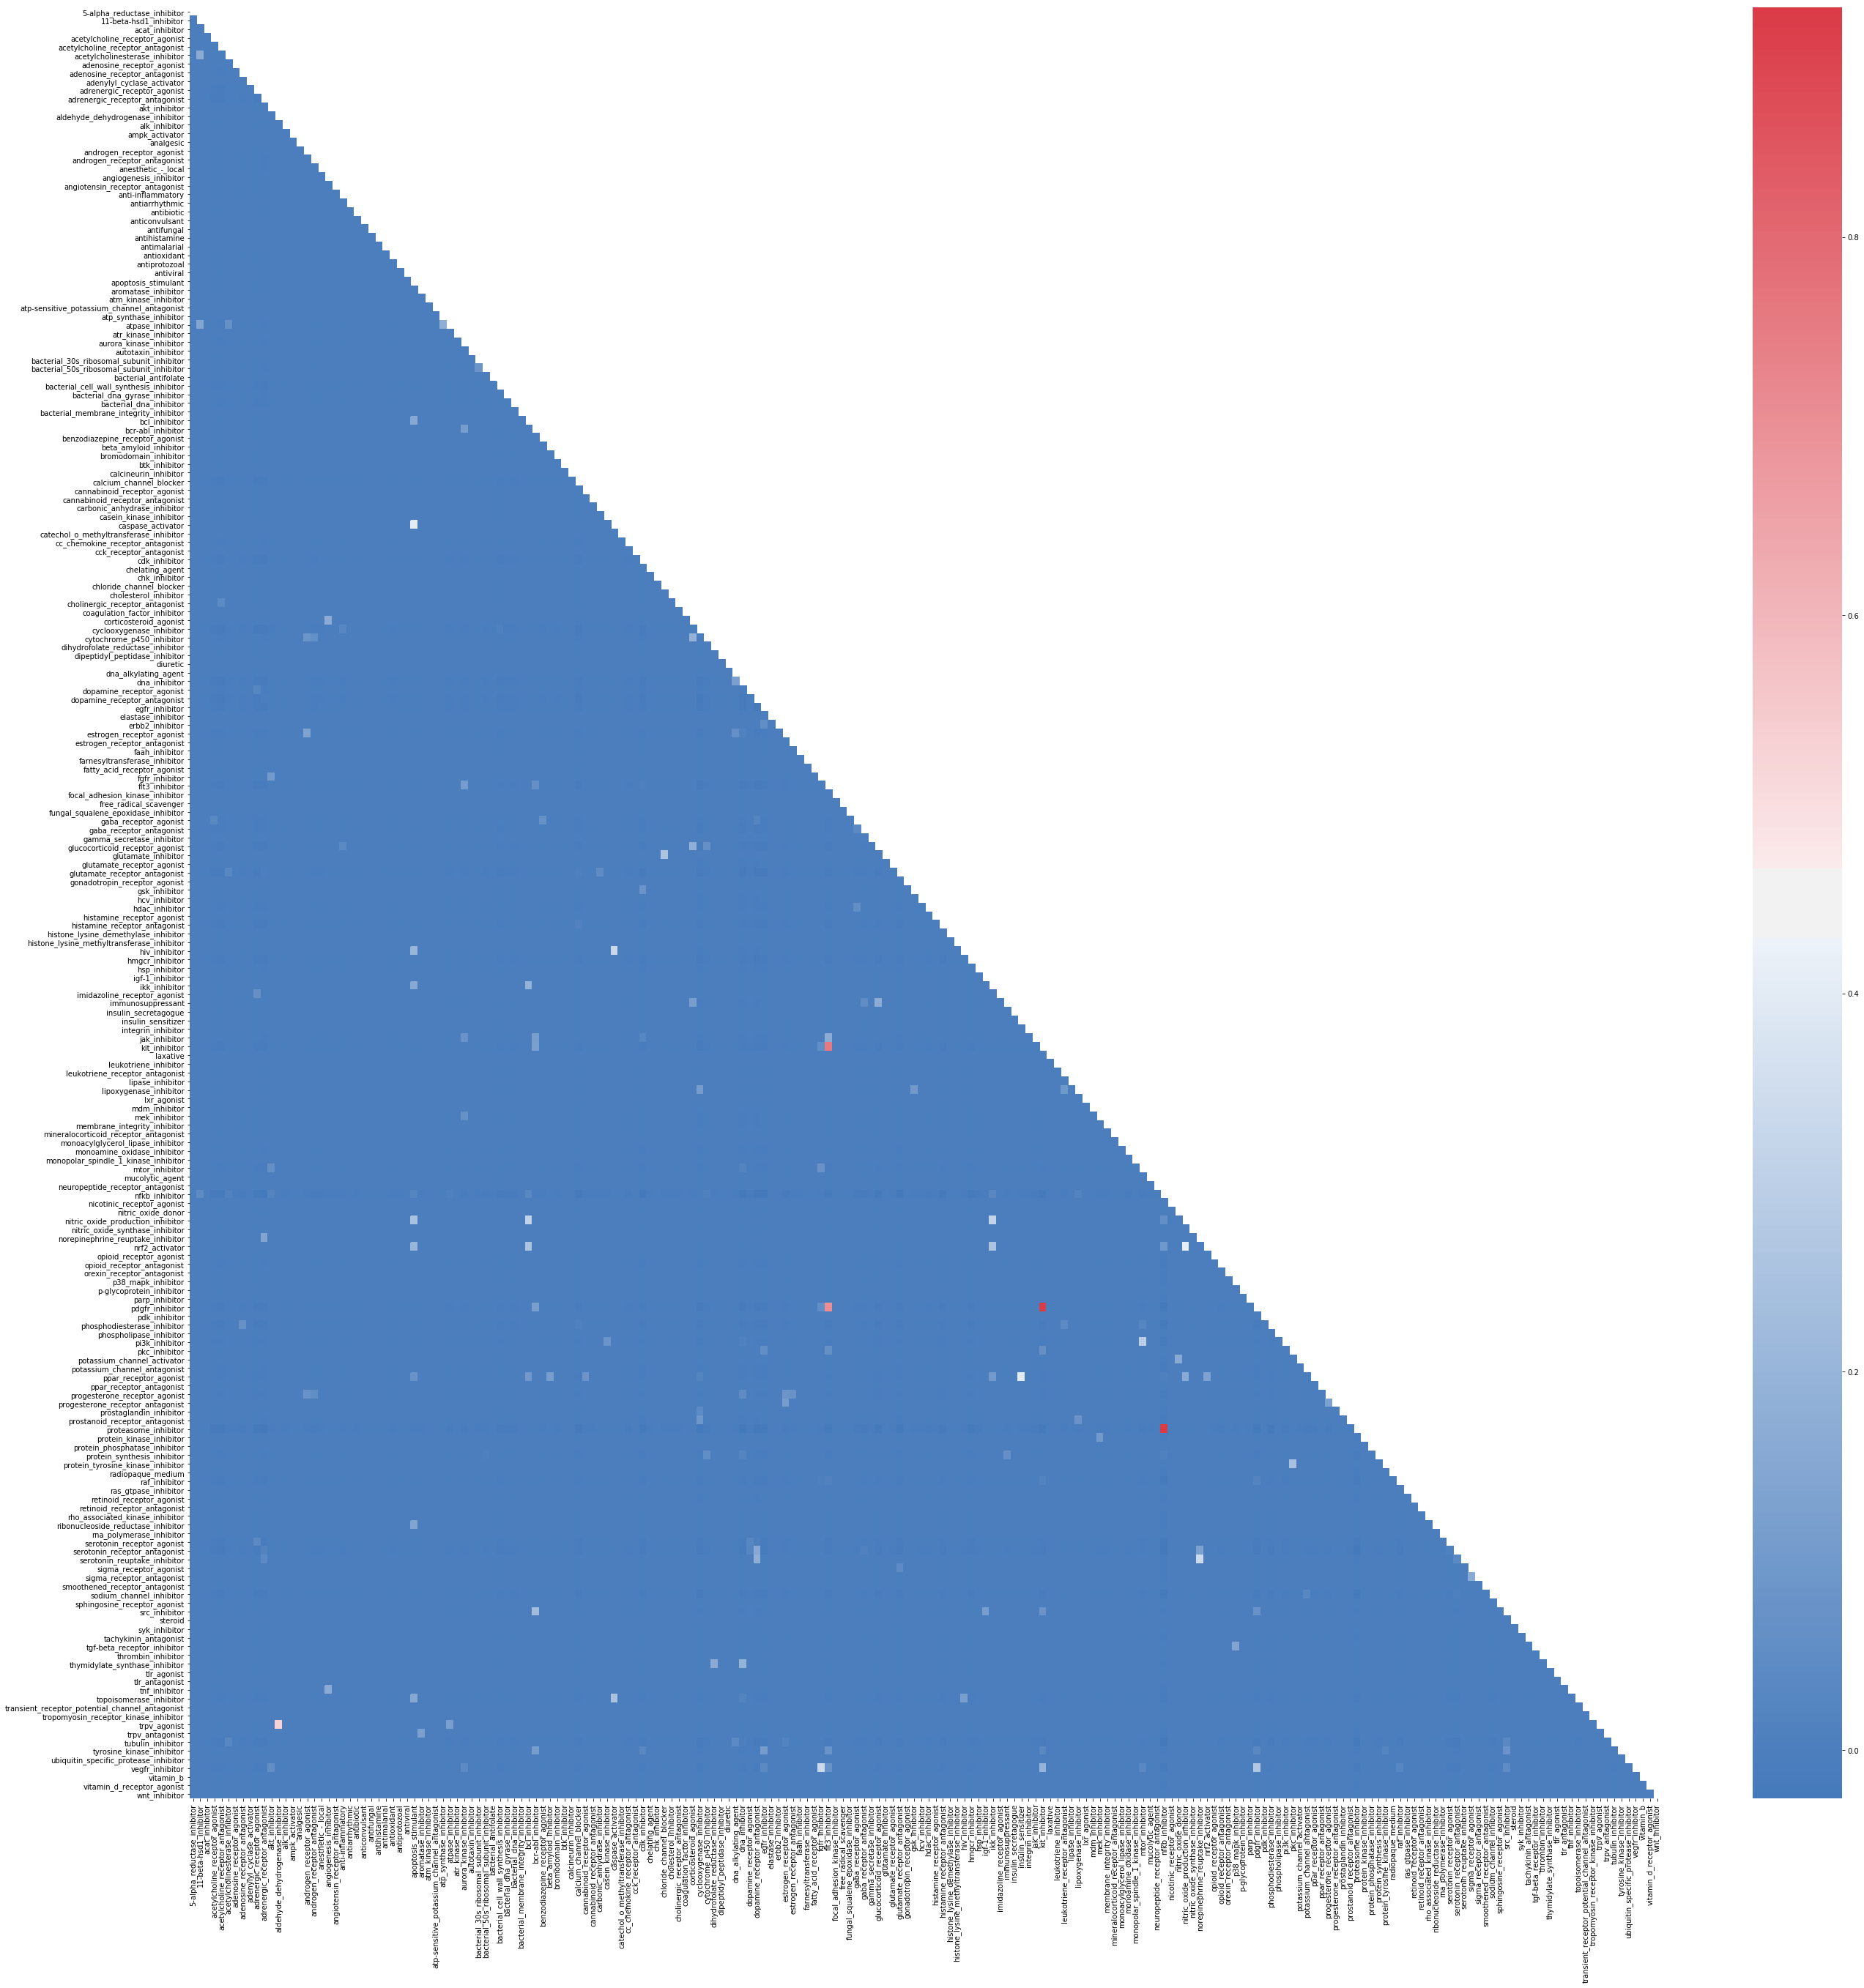

In [51]:
corr = target.corr()
f, ax = plt.subplots(figsize=(45, 45))
# Add diverging colormap from red to blue
cmap = sns.diverging_palette(250, 10, as_cmap=True)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# plot the heatmap
sns.heatmap(corr,  mask = mask,
        xticklabels=corr.columns,
        yticklabels=corr.columns , cmap=cmap)
plt.show()


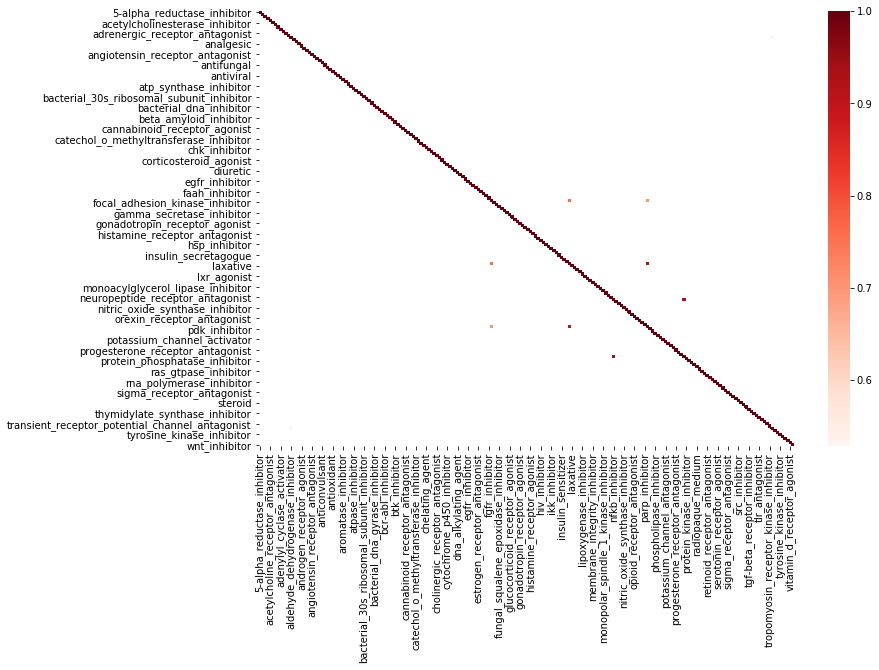

In [52]:
kot = corr[corr>=.5]
plt.figure(figsize=(12,8))
sns.heatmap(kot, cmap="Reds" )
plt.show()

# PCA

Given considerable amt of correlations amongst the gene and cell features, we might want to reduce the dimensionality of the data. PCA is a method designed for this.